# TEXT MINING PROJECT - GENDER POLITICS

In [ ]:
!pip install pandarallel p_tqdm

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk

from datetime import datetime

from tqdm import tqdm
tqdm.pandas()

import multiprocessing as mp
from multiprocessing import Pool

from p_tqdm import p_map

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=2)

import seaborn as sns
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/nick/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/gender/')

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/gender/"

/content/drive/My Drive/Colab Notebooks/gender


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Pre-processing

In [ ]:
dataset = pd.read_csv("convocationsReportResult.csv", sep = ";")

In [ ]:
dataset.head()

,id,convocationid,downloadtime,text
0,9555,14593,2020-03-06 19:56:43.847,A t t i Parlamentari - 3016 - Camera dei Dep...
1,9480,14494,2020-03-06 19:55:34.845,C A M E R A DEI DEPUTATI \nI. \nSEDUTA ANTIHE...
2,9481,14495,2020-03-06 19:55:34.984,Aiti Parlahentarì - 7 - Caniera dei Deputali ...
3,9482,14497,2020-03-06 19:55:36.212,Atti ' Parlamentari - 15 - Camera dei Deputati...
4,9483,14498,2020-03-06 19:55:36.343,Atti Parlamentari - 59 - Camera dei Deputali \...


We remove the speeches made by the presidents of each session.
Next, we define a function called "get_session_text".
We take the very same columns we have and ask the function to split the text (therefore, the variable x becomes the dataframe) whenever it finds "La seduta comincia", since by looking at the text we found this recursive pattern. Normally after the "La seduta comincia" we have a space and a timestamp; it is in position "\n". Therefore, we need to remove all that part (pos = test.find("\n"), whenever it finds that specific expression.

In [ ]:
def get_president_from_text(x):
    idx = x.find("PRESIDENZ")
    pres = x[idx+11:]
    idx = pres.find("\n")
    pres = pres[:idx]
    splt = pres.split()

    if len(splt) > 0:
        return splt[-1]
    else:
        return ""

In [ ]:
def get_session_text(x):
    col = ['id', 'convocationid', 'downloadtime', 'text', 'session_text', 'president', 'cleaned']
    splitted = x.text.split("La seduta comincia")

    presidente = get_president_from_text(x.text)

    if len(splitted) == 2:
        testo = splitted[1]
        pos = testo.find("\n")

        end = -1
        if 'PAGINA BIANCA' in testo:
            end = testo.find('PAGINA BIANCA')

        if end != -1:
            return pd.Series([x.id, x.convocationid, x.downloadtime, x.text, testo[pos + 1:end], presidente, True], index=col) 
        else:
            return pd.Series([x.id, x.convocationid, x.downloadtime, x.text, testo[pos + 1:], presidente, True], index=col) 
        
    else:
        return pd.Series([x.id, x.convocationid, x.downloadtime, x.text, x.text, presidente, False], index=col)

In [ ]:
dataset = dataset.progress_apply(get_session_text, axis=1)

100%|██████████| 3736/3736 [00:03<00:00, 1130.23it/s]


In [ ]:
dataset.head()

,id,convocationid,downloadtime,text,session_text,president,cleaned
0,9555,14593,2020-03-06 19:56:43.847,A t t i Parlamentari - 3016 - Camera dei Dep...,"CUADALUPI, Segrctnrio, legge i I pro- \ncesso ...",TARGETTI,True
1,9480,14494,2020-03-06 19:55:34.845,C A M E R A DEI DEPUTATI \nI. \nSEDUTA ANTIHE...,Costituzione deU’UBcio provvisorio \ndi Presid...,LONGHENA,True
2,9481,14495,2020-03-06 19:55:34.984,Aiti Parlahentarì - 7 - Caniera dei Deputali ...,Insediamento e discorsb del Presidente. \nPRES...,EONGHENA,True
3,9482,14497,2020-03-06 19:55:36.212,Atti ' Parlamentari - 15 - Camera dei Deputati...,"RICCIO, Segretario, legge il processo ver- \nb...",GRQNCIQI,True
4,9483,14498,2020-03-06 19:55:36.343,Atti Parlamentari - 59 - Camera dei Deputali \...,"SULLO, Segretario, leg3e il processo ver- \n(E...",GRONCHI,True


In [ ]:
#Let's count the booleans.
dataset.cleaned.value_counts()

True     3579
False     157
Name: cleaned, dtype: int64

In [ ]:
#Let's check the sessions that it didn't recognize.
not_cleaned = dataset[dataset['cleaned']==False]

In [ ]:
not_cleaned.head()

,id,convocationid,downloadtime,text,session_text,president,cleaned
6,9485,14500,2020-03-06 19:55:37.287,Atli Parlam.entari - 77 - Camera dei Deputati ...,Atli Parlam.entari - 77 - Camera dei Deputati ...,GRONCHI,False
7,9486,14502,2020-03-06 19:55:38.295,Alti Parlamentari - 111 - Camera dei Deputali...,Alti Parlamentari - 111 - Camera dei Deputali...,GRONCHK,False
12,9491,14508,2020-03-06 19:55:42.826,~~ \nDISCUSSIONI - SEDUTA D E L L ' ~ ~ GI-UG...,~~ \nDISCUSSIONI - SEDUTA D E L L ' ~ ~ GI-UG...,MARTINO,False
28,9507,14530,2020-03-06 19:55:55.088,Alli Parlamenlari - 869 - Camera dei Deputali...,Alli Parlamenlari - 869 - Camera dei Deputali...,TARGETTI,False
33,9512,14536,2020-03-06 19:55:59.671,Atti Pariamentari - 1041 - Camera dei Deputati...,Atti Pariamentari - 1041 - Camera dei Deputati...,TARGETTI,False


In [ ]:
# Let's check those texts where we were not able to extract the president
no_president = dataset[dataset['president']==""]
no_president.head()

,id,convocationid,downloadtime,text,session_text,president,cleaned
243,9723,14814,2020-03-06 20:00:17.209,Atti Parlamentari --. 12204 - Camera dei Depvt...,"MAZZA, Segretario, legge il ;Jrocesso ver. \n(...",,True
1678,12960,19076,2020-03-06 21:00:47.83,Atti Parlamentari - 3759 - . Camera dei Deputa...,"MAZZARINO, Segretario, legge il proces- \nso v...",,True
2548,17238,25536,2020-03-06 22:36:00.553,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,False
2549,17239,25538,2020-03-06 22:36:01.084,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,False


In [ ]:
# Remove those lines where we were not able to get the text or get the president name
dataset = dataset.loc[dataset["president"] != ""]
dataset = dataset.loc[dataset["cleaned"] == True]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577 entries, 0 to 3735
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3577 non-null   int64 
 1   convocationid  3577 non-null   int64 
 2   downloadtime   3577 non-null   object
 3   text           3577 non-null   object
 4   session_text   3577 non-null   object
 5   president      3577 non-null   object
 6   cleaned        3577 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 199.1+ KB


Now we want to get the single intervention and clean it.

In [ ]:
speeches = []

def isRomanNumber(x):
    match = re.match(r"^(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})$", x)
  
    if match is not None:
        return True
    else:
        return False

def get_speech(x):
    pattern = r"(?:\n)+(\b[A-Z ]+\b)"
    l = re.finditer(pattern, x.session_text)
  
    custom_stopwords = ['LEGISLATURA', 'PAGINA BIANCA',
                        'STENOGRAFICO', 'STENOGRAFIA',
                        'TIPOGRAFIA', 'DISCUSSIONI',
                        'SEDUTA', 'VOTAZIONI', 'DISCUS']
  
    results = []
    for match in l:
        name = str(match.group(0)).strip()

        if name != '\\n' and (len(name) > 1) and not any(w in name for w in custom_stopwords) and not isRomanNumber(name):
            results.append([name, match.start(), match.end()])

    toRemove = []
    for i, item in enumerate(results):
        if i+1 < len(results):
            if item[2] == results[i+1][1]:
                if i not in toRemove:
                    toRemove.append(i)

                if i+1 not in toRemove:
                    toRemove.append(i+1)

    [results.pop(i) for i in sorted(toRemove, reverse=True)]

    for i, item in enumerate(results):
        if i+1 < len(results):
            speech = x.session_text[item[2]:results[i+1][1]]
        elif i+1 == len(results):
            speech = x.session_text[item[2]:]

        #dep = x.presidente if item[0] == "PRESIDENTE" else item[0]
        dep = item[0]

        speeches.append([x.convocationid, dep, speech.strip()])

In [ ]:
_ = dataset.progress_apply(get_speech, axis=1)

100%|██████████| 3577/3577 [01:05<00:00, 54.98it/s] 


In [ ]:
df_speeches = pd.DataFrame(speeches, columns=['convocationid', 'deputy', 'text'])

In [ ]:
# Remove those speeches made by the presidents
df_speeches = df_speeches[df_speeches.deputy != "PRESIDENTE"]

In [ ]:
df_speeches.dropna(subset=['text'], inplace = True)

In [ ]:
df_speeches.tail(7)

,convocationid,deputy,text
779410,25970,RENATO BRUNETTA,"(FI). Presidente,\nsignor Ministro, voteremo a..."
779412,25970,VANNIA GAVA,"(LEGA). Grazie Presidente,\nonorevoli colleghi..."
779414,25970,DAVIDE CRIPPA,"(M5S). Grazie Presidente,\ncolleghi, concittad..."
779416,25970,NUNZIO ANGIOLA,"(MISTO). Presidente,\ncari colleghi, cari Mini..."
779418,25970,NUNZIO ANGIOLA,"(MISTO). Mi avvio\na concludere. Ecco perché, ..."
779420,25970,VITTORIO SGARBI,"(M-NI-USEI-C!-AC).\nCertamente, onorevole Pres..."
779424,25970,LAURA CASTELLI,", Sottosegretaria di\nStato per l'Economia e l..."


In [ ]:
df_speeches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538547 entries, 2 to 779424
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   convocationid  538547 non-null  int64 
 1   deputy         538547 non-null  object
 2   text           538547 non-null  object
dtypes: int64(1), object(2)
memory usage: 16.4+ MB


In [ ]:
df_speeches.to_csv('discorsi.csv', index=False)

Reload the already manipulated csv if we are starting from here

In [ ]:
df_speeches = pd.read_csv("discorsi.csv")

In [ ]:
stopwords = nltk.corpus.stopwords.words('italian')
stopwords.extend(string.punctuation)

In [ ]:
#Classic text cleaning 

def cleanText(x):
    txt = str(x).lower()
    #txt = re.sub(r'\n', '', x)
    tokens = nltk.word_tokenize(txt)
    words = [word for word in tokens if word.isalpha()]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [w for w in stripped if w.isalpha() and not w in stopwords]
    txt = " ".join(words)
        
    txt = re.sub(' +', ' ', txt)
    
    return txt

In [ ]:
df_speeches["text"] = df_speeches.text.progress_apply(cleanText)

100%|██████████| 538547/538547 [21:00<00:00, 427.26it/s]  


In [ ]:
df_speeches.drop(df_speeches.loc[df_speeches['text']==""].index, inplace=True)

In [ ]:
df_speeches.head()

,convocationid,deputy,text
0,14593,VIVIANI LUCIANA,onorevole mini stro rivolgo visto d onorevoli ...
1,14593,SCELBA,minis t ro interno mini stero interno entra af...
2,14593,VIVIANI LUCIANA,circolare co munque emanata ministero interno ...
3,14593,SCELBA,mini s t ro interno vigore tutte funzioni pass...
4,14593,VIVIANI LUCIANA,passaggio av venuto molto recentemente determi...


In [ ]:
df_speeches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532789 entries, 0 to 538546
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   convocationid  532789 non-null  int64 
 1   deputy         532687 non-null  object
 2   text           532789 non-null  object
dtypes: int64(1), object(2)
memory usage: 16.3+ MB


In [ ]:
df_speeches.to_csv("discorsi_cleaned.csv", index=False)

Restart kernel and reload csv to free up memory

In [ ]:
df_speeches = pd.read_csv("discorsi_cleaned.csv")

In [1]:
#Download data from dati.camera in order to get legsilature for each speech, the gender of each deputy and her/his party

legis = list(range(1, 19))
for legi in tqdm(legis):
    df_dep = pd.read_csv(r"http://dati.camera.it/sparql?query=%23%23%23%23+tutti+i+deputati+nella+XVI+Legislatura+con+info%2C+estremi+di+mandato+e+numero+totale+di+mandati+%0D%0A%23%23%23%23+%28anche+successivi%29+%0D%0A%23%23%23%23+%28la+URI+%3Chttp%3A%2F%2Fdati.camera.it%2Focd%2Flegislatura.rdf%2Frepubblica_16%3E+identifica+la+Legislatura%29%0D%0A%0D%0ASELECT+DISTINCT+%3Fpersona+%3Fcognome+%3Fnome+%3Finfo%0D%0A%3FdataNascita+%3FluogoNascita+%3Fgenere+%3FnomeGruppo+%3FinizioMandato+%3FfineMandato%0D%0A%3Fcollegio++COUNT%28DISTINCT+%3FmadatoCamera%29+as+%3FnumeroMandati+%3Faggiornamento+%0D%0AWHERE+%7B%0D%0A%3Fpersona+ocd%3Arif_mandatoCamera+%3Fmandato%3B+a+foaf%3APerson.%0D%0A%0D%0A%23%23+deputato%0D%0A%3Fd+a+ocd%3Adeputato%3B+ocd%3Aaderisce+%3Faderisce%3B%0D%0Aocd%3Arif_leg+%3Chttp%3A%2F%2Fdati.camera.it%2Focd%2Flegislatura.rdf%2Frepubblica_"+ "{:02d}".format(legi) + r"%3E%3B%0D%0Aocd%3Arif_mandatoCamera+%3Fmandato.%0D%0AOPTIONAL%7B%3Fd+dc%3Adescription+%3Finfo%7D%0D%0A%0D%0A%23%23anagrafica%0D%0A%3Fd+foaf%3Asurname+%3Fcognome%3B+foaf%3Agender+%3Fgenere%3Bfoaf%3AfirstName+%3Fnome.%0D%0AOPTIONAL%7B%0D%0A%3Fpersona+%3Chttp%3A%2F%2Fpurl.org%2Fvocab%2Fbio%2F0.1%2FBirth%3E+%3Fnascita.%0D%0A%3Fnascita+%3Chttp%3A%2F%2Fpurl.org%2Fvocab%2Fbio%2F0.1%2Fdate%3E+%3FdataNascita%3B+%0D%0Ardfs%3Alabel+%3Fnato%3B+ocd%3Arif_luogo+%3FluogoNascitaUri.+%0D%0A%3FluogoNascitaUri+dc%3Atitle+%3FluogoNascita.+%0D%0A%7D%0D%0A%23%23aggiornamento+del+sistema%0D%0AOPTIONAL%7B%3Fd+%3Chttp%3A%2F%2Flod.xdams.org%2Fontologies%2Fods%2Fmodified%3E+%3Faggiornamento.%7D%0D%0A%23%23+mandato%0D%0A%3Fmandato+ocd%3Arif_elezione+%3Felezione.++%0D%0AOPTIONAL%7B%3Fmandato+ocd%3AendDate+%3FfineMandato.%7D%0D%0AOPTIONAL%7B%3Fmandato+ocd%3AstartDate+%3FinizioMandato.%7D%0D%0A+%0D%0A%23%23+totale+mandati%0D%0A%3Fpersona+ocd%3Arif_mandatoCamera+%3FmadatoCamera.%0D%0A+%0D%0A%23%23+elezione%0D%0A%3Felezione+dc%3Acoverage+%3Fcollegio.%0D%0A++%0D%0A%23%23+adesione+a+gruppo%0D%0AOPTIONAL%7B%0D%0A++%3Faderisce+ocd%3Arif_gruppoParlamentare+%3Fgruppo.%0D%0A++%3Fgruppo+%3Chttp%3A%2F%2Fpurl.org%2Fdc%2Fterms%2Falternative%3E+%3Fsigla.%0D%0A++%3Fgruppo+dc%3Atitle+%3FnomeGruppo.%0D%0A%7D%0D%0A+%0D%0A%7D&debug=on&default-graph-uri=&format=text%2Fcsv")
    df_dep["legislatura"] = legi
    df_dep.to_csv("deputati/legi" + "{:02d}".format(legi) + ".csv", index=False)

NameError: ignored

In [ ]:
import glob, os

files = glob.glob('deputati/legi*')
files.sort()

In [ ]:
files

['deputati/legi01.csv',
 'deputati/legi02.csv',
 'deputati/legi03.csv',
 'deputati/legi04.csv',
 'deputati/legi05.csv',
 'deputati/legi06.csv',
 'deputati/legi07.csv',
 'deputati/legi08.csv',
 'deputati/legi09.csv',
 'deputati/legi10.csv',
 'deputati/legi11.csv',
 'deputati/legi12.csv',
 'deputati/legi13.csv',
 'deputati/legi14.csv',
 'deputati/legi15.csv',
 'deputati/legi16.csv',
 'deputati/legi17.csv',
 'deputati/legi18.csv']

In [ ]:
#We put all legis into one df
df = pd.concat(map(lambda file: pd.read_csv(file), files))

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
#We use df_1 only for gender; while df for all info
df_1 = pd.concat(map(lambda file: pd.read_csv(file, usecols=['cognome', 'nome', 'genere']), files))

In [ ]:
df_1.drop_duplicates(inplace=True)

In [ ]:
df_1 = df_1.reset_index()

In [ ]:
#We create new columns in order to get gender (we need the combinations of name and surname)
#Deputies are reported in different ways in speeches, we need to consider all variations
df_1["name_surname"] = df_1.parallel_apply(lambda x: x.nome + " " + x.cognome, axis=1)

In [ ]:
df_1["surname_name"] = df_1.parallel_apply(lambda x: x.cognome + " " + x.nome, axis=1)

In [ ]:
df_1.to_csv("lista_deputati.csv", index=False)

In [ ]:
df_1 = pd.read_csv("lista_deputati.csv")

In [ ]:
df_1.genere.value_counts()

male      4773
female     824
Name: genere, dtype: int64

<AxesSubplot:xlabel='genere', ylabel='count'>

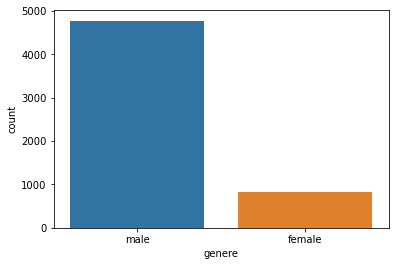

In [ ]:
#Gender distr of all deputies ever (also those of legislature we won't analyze)
sns.countplot(df_1.genere)

In [ ]:
#We get the gender of each deputy
#We consider first the combination surname_name; we take all indexes of rows of records which correspond to this structure;
#if we get a result we stick with the gender we found.
#If we don't find any correspondence, we get to the next structure name_surname; lastly, we only consider surname.
#If we don't find no matches whatsoever, we leave it empty. 

def get_dep_sex(x):
    idxs = df_1.loc[df_1.surname_name.isin([x.deputy])].index.tolist()
    if (len(idxs) > 0):
        return df_1.iloc[idxs[0]].genere
    else:
        idxs = df_1.loc[df_1.name_surname.isin([x.deputy])].index.tolist()
        if (len(idxs) > 0):
            return df_1.iloc[idxs[0]].genere
        else:
            idxs = df_1.loc[df_1.cognome.isin([x.deputy])].index.tolist()
            if (len(idxs) > 0):
                return df_1.iloc[idxs[0]].genere
            else:
                return ""

In [ ]:
df_speeches["gender"] = df_speeches.progress_apply(get_dep_sex, axis=1)

100%|██████████| 532789/532789 [10:46<00:00, 823.53it/s] 


In [ ]:
df_speeches.head()

,convocationid,deputy,text,gender
0,14593,VIVIANI LUCIANA,onorevole mini stro rivolgo visto d onorevoli ...,female
1,14593,SCELBA,minis t ro interno mini stero interno entra af...,male
2,14593,VIVIANI LUCIANA,circolare co munque emanata ministero interno ...,female
3,14593,SCELBA,mini s t ro interno vigore tutte funzioni pass...,male
4,14593,VIVIANI LUCIANA,passaggio av venuto molto recentemente determi...,female


In [ ]:
df_speeches.gender.value_counts()

male      312328
          180044
female     40417
Name: gender, dtype: int64

In [ ]:
df_speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532789 entries, 0 to 532788
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   convocationid  532789 non-null  int64 
 1   deputy         532687 non-null  object
 2   text           528095 non-null  object
 3   gender         532789 non-null  object
dtypes: int64(1), object(3)
memory usage: 16.3+ MB


In [ ]:
#Remove speeches of which we couldn't find the gender of the deputy
df_speeches.drop(df_speeches.loc[df_speeches["gender"]==""].index, inplace=True)

In [ ]:
# Binarize labels
df_speeches.gender = df_speeches.gender.parallel_apply(lambda x: 0 if x == "male" else 1)

In [ ]:
df_speeches.gender.value_counts()

0    312328
1     40417
Name: gender, dtype: int64

In [ ]:
# Get proportion of speech per gender
df_speeches.gender.value_counts(normalize=True)*100

0    88.542148
1    11.457852
Name: gender, dtype: float64

In [ ]:
df_speeches.to_csv("discorsi_cleaned.csv", index=False)

<AxesSubplot:xlabel='gender', ylabel='count'>

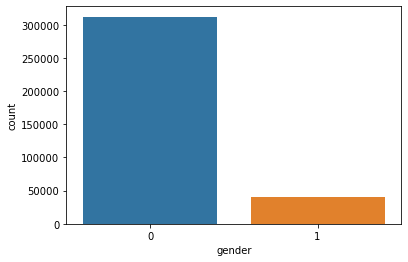

In [ ]:
#Distr gender of deputies of the speeches of the legis we are analyzing
sns.countplot(df_speeches.gender)

## Analysis

In [ ]:
df_speeches = pd.read_csv("discorsi_cleaned.csv")

In [ ]:
df_speeches.head()

,convocationid,deputy,text,gender
0,14593,VIVIANI LUCIANA,onorevole mini stro rivolgo visto d onorevoli ...,1
1,14593,SCELBA,minis t ro interno mini stero interno entra af...,0
2,14593,VIVIANI LUCIANA,circolare co munque emanata ministero interno ...,1
3,14593,SCELBA,mini s t ro interno vigore tutte funzioni pass...,0
4,14593,VIVIANI LUCIANA,passaggio av venuto molto recentemente determi...,1


We need now to match each speach to its corresponding legislature

In [ ]:
leg01 = pd.date_range(start="1948-05-08",end="1953-06-24").to_pydatetime().tolist()
leg02 = pd.date_range(start="1953-06-25",end="1958-06-11").to_pydatetime().tolist()
leg03 = pd.date_range(start="1958-06-12",end="1963-05-15").to_pydatetime().tolist()
leg04 = pd.date_range(start="1963-05-16",end="1968-06-04").to_pydatetime().tolist()
leg05 = pd.date_range(start="1968-06-05",end="1972-05-24").to_pydatetime().tolist()
leg06 = pd.date_range(start="1972-05-25",end="1976-07-04").to_pydatetime().tolist()
leg07 = pd.date_range(start="1976-07-05",end="1979-06-19").to_pydatetime().tolist()
leg08 = pd.date_range(start="1979-06-20",end="1983-07-11").to_pydatetime().tolist()
leg09 = pd.date_range(start="1983-07-12",end="1987-07-01").to_pydatetime().tolist()
leg10 = pd.date_range(start="1987-07-02",end="1992-04-22").to_pydatetime().tolist()
leg11 = pd.date_range(start="1992-04-23",end="1994-04-14").to_pydatetime().tolist()
leg12 = pd.date_range(start="1994-04-15",end="1996-05-08").to_pydatetime().tolist()
leg13 = pd.date_range(start="1996-05-09",end="2001-05-29").to_pydatetime().tolist()
leg14 = pd.date_range(start="2001-05-30",end="2006-04-27").to_pydatetime().tolist()
leg15 = pd.date_range(start="2006-04-28",end="2008-04-28").to_pydatetime().tolist()
leg16 = pd.date_range(start="2008-04-29",end="2013-03-14").to_pydatetime().tolist()
leg17 = pd.date_range(start="2013-03-15",end="2018-03-22").to_pydatetime().tolist()
leg18 = pd.date_range(start="2018-03-23",end=datetime.strftime(datetime.today(), '%Y-%m-%d')).to_pydatetime().tolist()

In [ ]:
legis = [leg01, leg02, leg03, 
         leg04, leg05, leg06,
         leg07, leg08, leg09,
         leg10, leg11, leg12,
         leg13, leg14, leg15,
         leg16, leg17, leg18]

In [ ]:
metadata = pd.read_csv("convocationsResult.csv", sep=";")

In [ ]:
metadata["date"] = metadata['date'].astype('datetime64[s]')

In [ ]:
metadata = metadata[["id", "date"]]

In [ ]:
df_speeches = df_speeches.merge(metadata, left_on='convocationid', right_on='id')

In [ ]:
#From above we have the list of each date for each legis.
#From the convocation_result.csv we have the date of the session. 
#From the convocation_id we can match each speech to its session, and therefore extract the date for the speech.
#We only consider the different ranges of legis and from them we can attribute the correct legis.

def get_legi(x):
    data1 = x.to_pydatetime()

    found = False
    i = 0

    while (found == False):
        leg = legis[i]

        if data1 in leg:
            found = True
            break

        i += 1
    
    return i + 1

In [ ]:
df_speeches["legislature"] = df_speeches.date.progress_apply(get_legi)

100%|██████████| 352745/352745 [01:09<00:00, 5049.48it/s]


In [ ]:
#How many speeches we have for each legis
df_speeches.legislature.value_counts()

17    92948
1     68337
5     63268
6     49089
7     45349
18    33754
Name: legislature, dtype: int64

In [ ]:
df_speeches = df_speeches[["convocationid", "deputy", "text", "gender", "date", "legislature"]]

In [ ]:
df_speeches.gender = df_speeches.gender.parallel_apply(lambda x: "male" if x == 0 else "female")

In [ ]:
#We count the gender of speakers for each speech for each legis
sp_per_geneder_per_leg = pd.crosstab(df_speeches.legislature, df_speeches.gender)
sp_per_geneder_per_leg["total"] = sp_per_geneder_per_leg["female"] + sp_per_geneder_per_leg["male"]
sp_per_geneder_per_leg

gender,female,male,total
legislature,,,
1,915,67422,68337
5,1645,61623,63268
6,1653,47436,49089
7,5453,39896,45349
17,20448,72500,92948
18,10303,23451,33754


The next step is to obtain the belonging party of each deputy and the period of time in which she/he belonged to it in a clearer way. We will raise the issue for which deputies change party during the very same legislature or among different legislatures.

In [ ]:
df["name_surname"] = df.parallel_apply(lambda x: x.nome + " " + x.cognome, axis=1)

In [ ]:
df["surname_name"] = df.parallel_apply(lambda x: x.cognome + " " + x.nome, axis=1)

In [ ]:
df["party"] = df.nomeGruppo.progress_apply(lambda x: x.split("(")[0].strip())

100%|██████████| 13419/13419 [00:00<00:00, 774357.02it/s]


In [ ]:
df["acronym"] = df.nomeGruppo.progress_apply(lambda x: x.split("(")[1].replace(")","").strip())

100%|██████████| 13419/13419 [00:00<00:00, 685404.55it/s]


In [ ]:
df["start"] = df.nomeGruppo.progress_apply(lambda x: x.split("(")[2].split("-")[0])

100%|██████████| 13419/13419 [00:00<00:00, 777792.04it/s]


In [ ]:
df["end"] = df.nomeGruppo.progress_apply(lambda x: x.split("(")[2].split("-")[1].replace(")", "") if "-" in x.split("(")[2] else datetime.strftime(datetime.today(), '%d.%m.%Y'))

100%|██████████| 13419/13419 [00:00<00:00, 290401.86it/s]


In [ ]:
#we verify that the columns in which we see when a deputy starts with a party we see if that value actually corresponds
#to a date time; if it doesn't, we drop the whole row (meaning the deputy).

def try_strptime(s):
    try:
        date = datetime.strptime(df.iloc[s].start, "%d.%m.%Y")
    except ValueError:
        return s
    return None

In [ ]:
to_rem = [try_strptime(i) for i in tqdm(range(df.shape[0]))]

100%|██████████| 13419/13419 [00:01<00:00, 7282.10it/s]


In [ ]:
to_rem = [i for i in to_rem if i is not None]

In [ ]:
df.drop(df.index[to_rem], inplace=True)
df = df.reset_index(drop=True)

In [ ]:
#We get the party for each deputy.
#We look at which day a speech has been made; the range we consider here is the one coming
#from the official records where we have the period of belonging to a party of each deputy; 
#We know the name of the deputy, match it with the corresponding row in the official records and if we find more rows
#it means that the person has belonged to more than one party.
#We choose the party in which we see the match between the date of that speech and the one of the party for that period.

def get_dep_party(x):
    idxs = df.loc[df.surname_name.isin([x.deputy])].index.tolist()
    
    if (len(idxs) > 0):
        if (len(idxs) == 1):
            return df.iloc[idxs[0]].party
        
        df_temp = df.iloc[idxs]
        df_temp = df_temp.reset_index(drop=True)
        for i in range(df_temp.shape[0]):
            range_date = pd.date_range(start=df_temp.iloc[i].start,end=df_temp.iloc[i].end).to_pydatetime().tolist()
            if x.date in range_date:
                return df_temp.iloc[i].party
    else:
        idxs = df.loc[df.name_surname.isin([x.deputy])].index.tolist()
        if (len(idxs) > 0):
            if (len(idxs) == 1):
                return df.iloc[idxs[0]].party
            
            df_temp = df.iloc[idxs]
            df_temp = df_temp.reset_index(drop=True)
            for i in range(df_temp.shape[0]):
                range_date = pd.date_range(start=df_temp.iloc[i].start,end=df_temp.iloc[i].end).to_pydatetime().tolist()
                if x.date in range_date:
                    return df_temp.iloc[i].party
        else:
            idxs = df.loc[df.cognome.isin([x.deputy])].index.tolist()
            if (len(idxs) > 0):
                if (len(idxs) == 1):
                    return df.iloc[idxs[0]].party
                
                df_temp = df.iloc[idxs]
                df_temp = df_temp.reset_index(drop=True)
                for i in range(df_temp.shape[0]):
                    range_date = pd.date_range(start=df_temp.iloc[i].start,end=df_temp.iloc[i].end).to_pydatetime().tolist()
                    if x.date in range_date:
                        return df_temp.iloc[i].party
            else:
                return ""

In [ ]:
df_speeches["party"] = df_speeches.progress_apply(get_dep_party, axis=1)

100%|██████████| 352745/352745 [31:02<00:00, 189.35it/s] 


In [ ]:
df_speeches.dropna(subset=["party"], inplace=True)

In [ ]:
df_speeches.to_csv("discorsi_cleaned_ext.csv", index=False)

In [ ]:
df_speeches = pd.read_csv("discorsi_cleaned_ext.csv")
df_speeches.head()

,convocationid,deputato,discorso,genere,date,legislatura,partito
0,14593,VIVIANI LUCIANA,onorevole mini stro rivolgo visto d onorevoli ...,female,1948-10-09,1,COMUNISTA
1,14593,SCELBA,minis t ro interno mini stero interno entra af...,male,1948-10-09,1,DEMOCRATICO CRISTIANO
2,14593,VIVIANI LUCIANA,circolare co munque emanata ministero interno ...,female,1948-10-09,1,COMUNISTA
3,14593,SCELBA,mini s t ro interno vigore tutte funzioni pass...,male,1948-10-09,1,DEMOCRATICO CRISTIANO
4,14593,VIVIANI LUCIANA,passaggio av venuto molto recentemente determi...,female,1948-10-09,1,COMUNISTA
...,...,...,...,...,...,...,...
352740,25970,DAVIDE CRIPPA,grazie presidente colleghi concittadini oggi d...,male,2020-03-11,18,MOVIMENTO 5 STELLE
352741,25970,NUNZIO ANGIOLA,misto presidente cari colleghi cari ministri u...,male,2020-03-11,18,MISTO
352742,25970,NUNZIO ANGIOLA,misto avvio concludere ecco caro presidente ca...,male,2020-03-11,18,MISTO
352743,25970,VITTORIO SGARBI,mniuseic ac certamente onorevole presidente cr...,male,2020-03-11,18,FORZA ITALIA - BERLUSCONI PRESIDENTE


In [ ]:
if "Unnamed: 0" in df_speeches.columns:
    df_speeches.drop(columns=["Unnamed: 0"], inplace=True)

From above we found that some deputies have made speeches when belonging to different parties (in the very same legislature or not). This is a problem when they made more than one speech in the same legislature but in different parties, because the count of gender distribution in the legsilature and the female/male representation in the party is counted for how many times they have switched party. 
In order to solve this problem and not alter gender distribution, we decided to keep only one party match for each deputy: the criterion used for this choice is based on the maximum number of speeches made by each speaker when belonging to a party. Therefore, a deputy will only have as party belonging the one in which they made the most interventions, even though they have switched party in the same legsilature.

The problem does not apply when they changed party in different legislature.

In [ ]:
# most speeches per party (mspp)
mspp = pd.crosstab(df_speeches.deputy, df_speeches.party)

In [ ]:
mspp

party,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CIVICI E INNOVATORI,COMUNISTA,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DEMOCRATICI DI SINISTRA - L'ULIVO,DEMOCRATICI DI SINISTRA-L'ULIVO,DEMOCRATICO CRISTIANO,DEMOCRATICO CRISTIANO - PARTITO POPOLARE ITALIANO,...,PARTITO SOCIALISTA ITALIANO DI UNITA' PROLETARIA,PARTITO SOCIALISTA UNITARIO,POPOLO DELLA LIBERTA',REPUBBLICANO,RIFONDAZIONE COMUNISTA,RIFONDAZIONE COMUNISTA - PROGRESSISTI,RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA
deputy,,,,,,,,,,,,,,,,,,,,,
ABBIATI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABBIATI DOLORES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABELLI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABRIGNANI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCAME,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZOSO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZUCCHINI,0,0,0,0,0,0,0,0,0,0,...,36,0,0,0,0,0,0,0,0,0
ZUCCONI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mspp_di = mspp.idxmax(axis=1)

In [ ]:
df_speeches["final_party"] = df_speeches.progress_apply(lambda x: mspp_di[x.deputy] if x.deputy in mspp_di else x.party, axis=1)

100%|██████████| 344862/344862 [00:07<00:00, 47611.00it/s]


In [ ]:
#These are those who changed parties
df[df.duplicated(["cognome", "nome"])]

,persona,cognome,nome,info,dataNascita,luogoNascita,genere,nomeGruppo,inizioMandato,fineMandato,collegio,numeroMandati,aggiornamento,legislatura,name_surname,surname_name,party,acronym,start,end
73,http://dati.camera.it/ocd/persona.rdf/p25480,CARAMIA,AGILULFO,NaN,18850606.0,SAN GIORGIO IONICO,male,PARTITO NAZIONALE MONARCHICO (PNM) (10.05.1948...,19480425,19530624.0,LECCE,2,2019-04-05 13:14:13,1,AGILULFO CARAMIA,CARAMIA AGILULFO,PARTITO NAZIONALE MONARCHICO,PNM,10.05.1948,24.06.1953
100,http://dati.camera.it/ocd/persona.rdf/p12330,SIMONINI,ALBERTO,"Funzionario di partito, sindacalista.",18960219.0,REGGIO NELL'EMILIA,male,PARTITO SOCIALISTA DEMOCRATICO ITALIANO (PSDI)...,19480430,19530624.0,CUN,4,2020-09-05 13:17:38,1,ALBERTO SIMONINI,SIMONINI ALBERTO,PARTITO SOCIALISTA DEMOCRATICO ITALIANO,PSDI,18.05.1951,24.06.1953
121,http://dati.camera.it/ocd/persona.rdf/p12330,SIMONINI,ALBERTO,"Funzionario di partito, sindacalista.",18960219.0,REGGIO NELL'EMILIA,male,PARTITO SOCIALISTA DEI LAVORATORI ITALIANI (PS...,19480430,19530624.0,CUN,4,2020-09-05 13:17:38,1,ALBERTO SIMONINI,SIMONINI ALBERTO,PARTITO SOCIALISTA DEI LAVORATORI ITALIANI,PSDI,31.01.1950,18.05.1951
134,http://dati.camera.it/ocd/persona.rdf/p3920,MATTEOTTI,GIANMATTEO,Laurea in scienze politiche; giornalista.,19210217.0,ROMA,male,PARTITO SOCIALISTA UNITARIO (PSU) (31.01.1950-...,19480424,19530624.0,VENEZIA,9,2020-09-05 12:35:21,1,GIANMATTEO MATTEOTTI,MATTEOTTI GIANMATTEO,PARTITO SOCIALISTA UNITARIO,PSU,31.01.1950,18.05.1951
154,http://dati.camera.it/ocd/persona.rdf/p17780,ARIOSTO,EGIDIO,Laurea in filosofia e pedagogia; insegnante,19110326.0,CASTO,male,UNITA' SOCIALISTA (US) (01.06.1948-31.01.1950),19480425,19530624.0,BRESCIA,5,2020-09-05 13:09:24,1,EGIDIO ARIOSTO,ARIOSTO EGIDIO,UNITA' SOCIALISTA,US,01.06.1948,31.01.1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13293,http://dati.camera.it/ocd/persona.rdf/p305866,PAGANI,ALBERTO,Laurea in scienze politiche; Professore a cont...,19710530.0,ALFONSINE,male,PARTITO DEMOCRATICO (PD) (27.03.2018,20180319,NaN,EMILIA-ROMAGNA - 01,2,2018-06-22 12:27:19,18,ALBERTO PAGANI,PAGANI ALBERTO,PARTITO DEMOCRATICO,PD,27.03.2018,18.09.2020
13295,http://dati.camera.it/ocd/persona.rdf/p301559,VALENTINI,VALENTINO,"Laurea di interprete, Master in business admin...",19620628.0,BOLOGNA,male,FORZA ITALIA - BERLUSCONI PRESIDENTE (FI) (27....,20180319,NaN,LOMBARDIA 1 - 02,4,2020-09-16 12:13:40,18,VALENTINO VALENTINI,VALENTINI VALENTINO,FORZA ITALIA - BERLUSCONI PRESIDENTE,FI,27.03.2018,18.09.2020
13298,http://dati.camera.it/ocd/persona.rdf/p307163,ROSPI,GIANLUCA,"Laurea in ingegneria edile, Dottorato di ricer...",19781223.0,MATERA,male,MOVIMENTO 5 STELLE (M5S) (27.03.2018,20180309,NaN,BASILICATA - 01,1,2020-09-15 12:13:56,18,GIANLUCA ROSPI,ROSPI GIANLUCA,MOVIMENTO 5 STELLE,M5S,27.03.2018,18.09.2020
13300,http://dati.camera.it/ocd/persona.rdf/p300447,LUPI,MAURIZIO ENZO,Laurea in Scienze politiche; Dirigente d'impresa,19591003.0,MILANO,male,MISTO (MISTO) (23.03.2018,20180313,NaN,LOMBARDIA 2 - 02,5,2020-09-16 12:13:16,18,MAURIZIO ENZO LUPI,LUPI MAURIZIO ENZO,MISTO,MISTO,23.03.2018,18.09.2020


In [ ]:
df[df.duplicated(["cognome", "nome"])].genere.value_counts()

male      6922
female     802
Name: genere, dtype: int64

In [ ]:
df[df.duplicated(["cognome", "nome", "nomeGruppo"])]

,persona,cognome,nome,info,dataNascita,luogoNascita,genere,nomeGruppo,inizioMandato,fineMandato,collegio,numeroMandati,aggiornamento,legislatura,name_surname,surname_name,party,acronym,start,end
216,http://dati.camera.it/ocd/persona.rdf/p13830,TANASCO,GIOVANNI,Laurea in giurisprudenza; avvocato.,18890209.0,CITTAVECCHIA,male,DEMOCRATICO CRISTIANO (DC) (01.06.1948-24.06.1...,19500927,19530624.0,CUN,2,2020-09-05 12:58:49,1,GIOVANNI TANASCO,TANASCO GIOVANNI,DEMOCRATICO CRISTIANO,DC,01.06.1948,24.06.1953
5480,http://dati.camera.it/ocd/persona.rdf/p14550,ARNONE,MARIO,Laurea in medicina e chirurgia; medico chirurgo,19280325.0,NOVARA,male,PARTITO COMUNISTA ITALIANO (PCI) (20.06.1979-1...,19820512,19820609.0,PALERMO,3,2020-09-05 13:17:24,8,MARIO ARNONE,ARNONE MARIO,PARTITO COMUNISTA ITALIANO,PCI,20.06.1979,11.07.1983
5897,http://dati.camera.it/ocd/persona.rdf/p14710,BONINO,EMMA,Laurea in lingue e letterature straniere; atti...,19480309.0,BRA,female,PARTITO RADICALE (RADICALE) (04.10.1983-01.07....,19830712,19830810.0,NAPOLI,9,2019-04-05 13:27:29,9,EMMA BONINO,BONINO EMMA,PARTITO RADICALE,RADICALE,04.10.1983,01.07.1987
6784,http://dati.camera.it/ocd/persona.rdf/p23910,MELELEO,SALVATORE,Laurea in medicina e chirurgia; medico chirurgo,19290724.0,CORIGLIANO D'OTRANTO,male,DEMOCRATICO CRISTIANO (DC) (09.07.1987-22.04.1...,19870629,19910321.0,LECCE,4,2020-09-05 13:03:03,10,SALVATORE MELELEO,MELELEO SALVATORE,DEMOCRATICO CRISTIANO,DC,09.07.1987,22.04.1992
6812,http://dati.camera.it/ocd/persona.rdf/p14710,BONINO,EMMA,Laurea in lingue e letterature straniere; atti...,19480309.0,BRA,female,FEDERALISTA EUROPEO (FED.EUR.) (16.07.1987-22....,19870625,19870702.0,CATANIA,9,2020-09-05 12:32:20,10,EMMA BONINO,BONINO EMMA,FEDERALISTA EUROPEO,FED.EUR.,16.07.1987,22.04.1992


In [ ]:
df_temp = df.drop_duplicates(["cognome", "nome", "legislatura"])

In [ ]:
#Final gender distribution for legis
genr_per_leg = pd.crosstab(df_temp.legislatura, df_temp.genere)
genr_per_leg["total"] = genr_per_leg["female"] + genr_per_leg["male"]
genr_per_leg = genr_per_leg.drop([2,3,4,8,9,10,11,12,13,14,15,16])
genr_per_leg

genere,female,male,total
legislatura,,,
1,45,567,612
5,18,641,659
6,26,633,659
7,54,597,651
17,206,465,671
18,231,413,644


In [ ]:
#Same as above in %
genr_per_leg_perc = pd.crosstab(df_temp.legislatura, df_temp.genere, normalize="index")*100
genr_per_leg_perc = genr_per_leg_perc.drop([2,3,4,8,9,10,11,12,13,14,15,16])
genr_per_leg_perc

genere,female,male
legislatura,,
1,7.352941,92.647059
5,2.731411,97.268589
6,3.945372,96.054628
7,8.294931,91.705069
17,30.700447,69.299553
18,35.869565,64.130435


In [ ]:
#Speeches distribution per gender per legislature in %
sp_per_gend_per_leg_perc = pd.crosstab(df_speeches.legislature, df_speeches.gender, normalize="index")*100
sp_per_gend_per_leg_perc

gender,female,male
legislature,,
1,1.333413,98.666587
5,2.600678,97.399322
6,3.357497,96.642503
7,12.261359,87.738641
17,22.086731,77.913269
18,30.524723,69.475277


In [ ]:
df_speeches.drop(columns=["party"], inplace=True)
df_speeches.rename(columns={"final_party":"party"},inplace=True)

In [ ]:
#Distribution of gender per party per legis (here we should have seen the duplicates when deputies have changed party)
distr_gend_per_part_per_leg = pd.crosstab(df.legislatura, [df.party, df.genere], dropna=False)
distr_gend_per_part_per_leg = distr_gend_per_part_per_leg.drop([2,3,4,8,9,10,11,12,13,14,15,16])
distr_gend_per_part_per_leg

party       ALLEANZA NAZIONALE       \
genere                  female male   
legislatura                           
1                            0    0   
5                            0    0   
6                            0    0   
7                            0    0   
17                           0    0   
18                           0    0   

party       ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA  \
genere                                                                female   
legislatura                                                                    
1                                                            0                 
5                                                            0                 
6                                                            0                 
7                                                            0                 
17                                                           7                 
18                                                           0                 

party             \
genere      male   
legislatura        
1              0   
5              0   
6              0   
7              0   
17            34   
18             0   

party       ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI  \
genere                                                               female   
legislatura                                                                   
1                                                            0                
5                                                            0                
6                                                            0                
7                                                            0                
17                                                          12                
18                                                           0                

party            CENTRO CRISTIANO DEMOCRATICO      CIVICI E INNOVATORI       \
genere      male                       female male              female male   
legislatura                                                                   
1              0                            0    0                   0    0   
5              0                            0    0                   0    0   
6              0                            0    0                   0    0   
7              0                            0    0                   0    0   
17            32                            0    0                  12   42   
18             0                            0    0                   0    0   

party        ... UNIONE DEMOCRATICA PER L'EUROPA       \
genere       ...                          female male   
legislatura  ...                                        
1            ...                               0    0   
5            ...                               0    0   
6            ...                               0    0   
7            ...                               0    0   
17           ...                               0    0   
18           ...                               0    0   

party       UNIONE DI CENTRO PER IL TERZO POLO      UNITA' SOCIALISTA       \
genere                                  female male            female male   
legislatura                                                                  
1                                            0    0                 1   34   
5                                            0    0                 0    0   
6                                            0    0                 0    0   
7                                            0    0                 0    0   
17                                           0    0                 0    0   
18                                           0    0                 0    0   

party        VERDE       VERDI       
genere      female male female male  
legislatura                  

In [ ]:
#Count of speeches per party per gender per legis
sp_per_party = pd.crosstab(df_speeches.legislature, [df_speeches.party, df_speeches.gender], dropna=False, margins=True, margins_name="Total")
sp_per_party

party       ALLEANZA NAZIONALE       \
gender                  female male   
legislature                           
1                            0    1   
5                            0    4   
6                            3    3   
7                            0    1   
17                           0    0   
18                           0    0   
Total                        3    9   

party       ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA  \
gender                                                                female   
legislature                                                                    
1                                                            0                 
5                                                            0                 
6                                                            1                 
7                                                            0                 
17                                                         256                 
18                                                           2                 
Total                                                      259                 

party             \
gender      male   
legislature        
1              0   
5              0   
6              0   
7              0   
17           970   
18            23   
Total        993   

party       ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI  \
gender                                                               female   
legislature                                                                   
1                                                            0                
5                                                            0                
6                                                            0                
7                                                            0                
17                                                         123                
18                                                          89                
Total                                                      212                

party            CIVICI E INNOVATORI       COMUNISTA         ...  \
gender      male              female  male    female   male  ...   
legislature                                                  ...   
1              1                   0     0       351  15297  ...   
5              0                   0     0       202    687  ...   
6              0                   0     0        68    355  ...   
7              0                   0     0        41    102  ...   
17           159                 446  2847         0     68  ...   
18            87                   0     0         1     17  ...   
Total        247                 446  2847       663  16526  ...   

party       RIFONDAZIONE COMUNISTA - PROGRESSISTI  \
gender                                       male   
legislature                                         
1                                               7   
5                                               2   
6                                               0   
7                                               0   
17                                              0   
18                                              0   
Total                                           9   

party       RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA       \
gender                                         female male   
legislature                                                  
1                                                   0    0   
5                                                   0    0   
6                                                   1    0   
7                                                   0    0   
17                                                  0    0   
18                                                  0    4   
Total                                         

In [ ]:
sp_per_party_perc = pd.crosstab(df_speeches.legislature, [df_speeches.party, df_speeches.gender], dropna=False, normalize="index")*100
sp_per_party_perc

party       ALLEANZA NAZIONALE            \
gender                  female      male   
legislature                                
1                     0.000000  0.001497   
5                     0.000000  0.006551   
6                     0.006359  0.006359   
7                     0.000000  0.002259   
17                    0.000000  0.000000   
18                    0.000000  0.000000   

party       ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA  \
gender                                                                female   
legislature                                                                    
1                                                     0.000000                 
5                                                     0.000000                 
6                                                     0.002120                 
7                                                     0.000000                 
17                                                    0.278724                 
18                                                    0.005936                 

party                  \
gender           male   
legislature             
1            0.000000   
5            0.000000   
6            0.000000   
7            0.000000   
17           1.056104   
18           0.068261   

party       ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI  \
gender                                                               female   
legislature                                                                   
1                                                     0.000000                
5                                                     0.000000                
6                                                     0.000000                
7                                                     0.000000                
17                                                    0.133918                
18                                                    0.264142                

party                 CIVICI E INNOVATORI          COMUNISTA             ...  \
gender           male              female     male    female       male  ...   
legislature                                                              ...   
1            0.001497             0.00000  0.00000  0.525284  22.892504  ...   
5            0.000000             0.00000  0.00000  0.330817   1.125104  ...   
6            0.000000             0.00000  0.00000  0.144135   0.752469  ...   
7            0.000000             0.00000  0.00000  0.092632   0.230451  ...   
17           0.173114             0.48559  3.09972  0.000000   0.074036  ...   
18           0.258206             0.00000  0.00000  0.002968   0.050454  ...   

party       RIFONDAZIONE COMUNISTA - PROGRESSISTI            \
gender                                     female      male   
legislature                                                   
1                                             0.0  0.010476   
5                                             0.0  0.003275   
6                                             0.0  0.000000   
7                                             0.0  0.000000   
17                                            0.0  0.000000   
18                                            0.0  0.000000   

party       RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA            \
gender                                         female      male   
legislature                                                       
1                                             0.00000  0.000000   
5                                             0.00000  0.000000   
6                                             0.00212  0.000000   
7                                             0.00000  0.000000   
17                                            0.00000  0.000000   
18                                            0.00000  0.011872   

party       SINISTRA ITALIANA - SINISTRA ECOLOGIA L

<AxesSubplot:xlabel='legislatura', ylabel='female'>

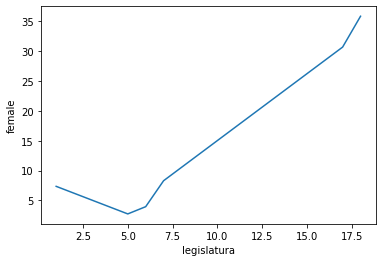

In [ ]:
sns.lineplot(data=genr_per_leg_perc, x=genr_per_leg_perc.index, y="female")
#the % of women per legis

<AxesSubplot:xlabel='legislature', ylabel='female'>

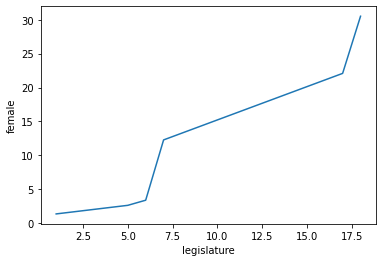

In [ ]:
sns.lineplot(data=sp_per_gend_per_leg_perc, x=sp_per_gend_per_leg_perc.index, y="female")
#the % of speeches of women per legis

In [ ]:
parties1 = np.sort(df.party.unique())
parties1 = np.delete(parties1,0)

In [1]:
#1) Number of fem per party / tot dept per legis
#See how the female representation per party inside the chamber changes wrt gender only per legis

In [ ]:
result1=distr_gend_per_part_per_leg["ALLEANZA NAZIONALE", "female"]/genr_per_leg["total"]
for party in tqdm(parties1):
    res = distr_gend_per_part_per_leg[party, "female"]/genr_per_leg["total"]
    result1 = pd.concat([result1, res], axis="columns")

100%|██████████| 85/85 [00:00<00:00, 1090.61it/s]


In [ ]:
result1.columns = np.sort(df.party.unique())
result1 = result1.fillna(0)

In [ ]:
#result1 = result1.drop([2,3,4,8,9,10,11,12,13,14,15,16])
result1

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CENTRO CRISTIANO DEMOCRATICO,CIVICI E INNOVATORI,COMUNISTA,COMUNISTI ITALIANI,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DCA-DEMOCRAZIA CRISTIANA PER LE AUTONOMIE-NUOVO PSI,DEMOCRATICI - L'ULIVO,...,SINISTRA DEMOCRATICA. PER IL SOCIALISMO EUROPEO,SINISTRA INDIPENDENTE,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,SOCIALISTI E RADICALI-RNP,UDR - UNIONE DEMOCRATICA PER LA REPUBBLICA,UNIONE DEMOCRATICA PER L'EUROPA,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA,VERDE,VERDI
legislatura,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.0,0.000000,0.034314,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001634,0.0,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.001536,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
17,0.0,0.010432,0.017884,0.0,0.017884,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.019374,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
18,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
result1_filtered = result1.loc[:, (result1 != 0).any(axis=0)]

<AxesSubplot:xlabel='legislatura'>

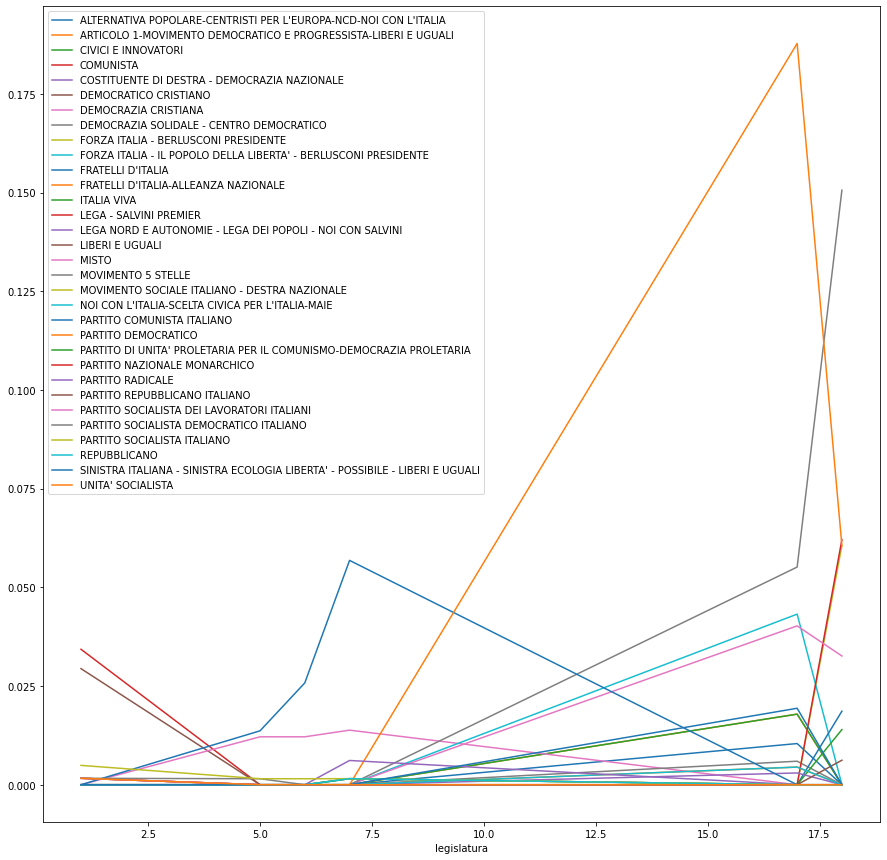

In [ ]:
result1_filtered.plot.line(figsize=(15,15))

array([<AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <Axe

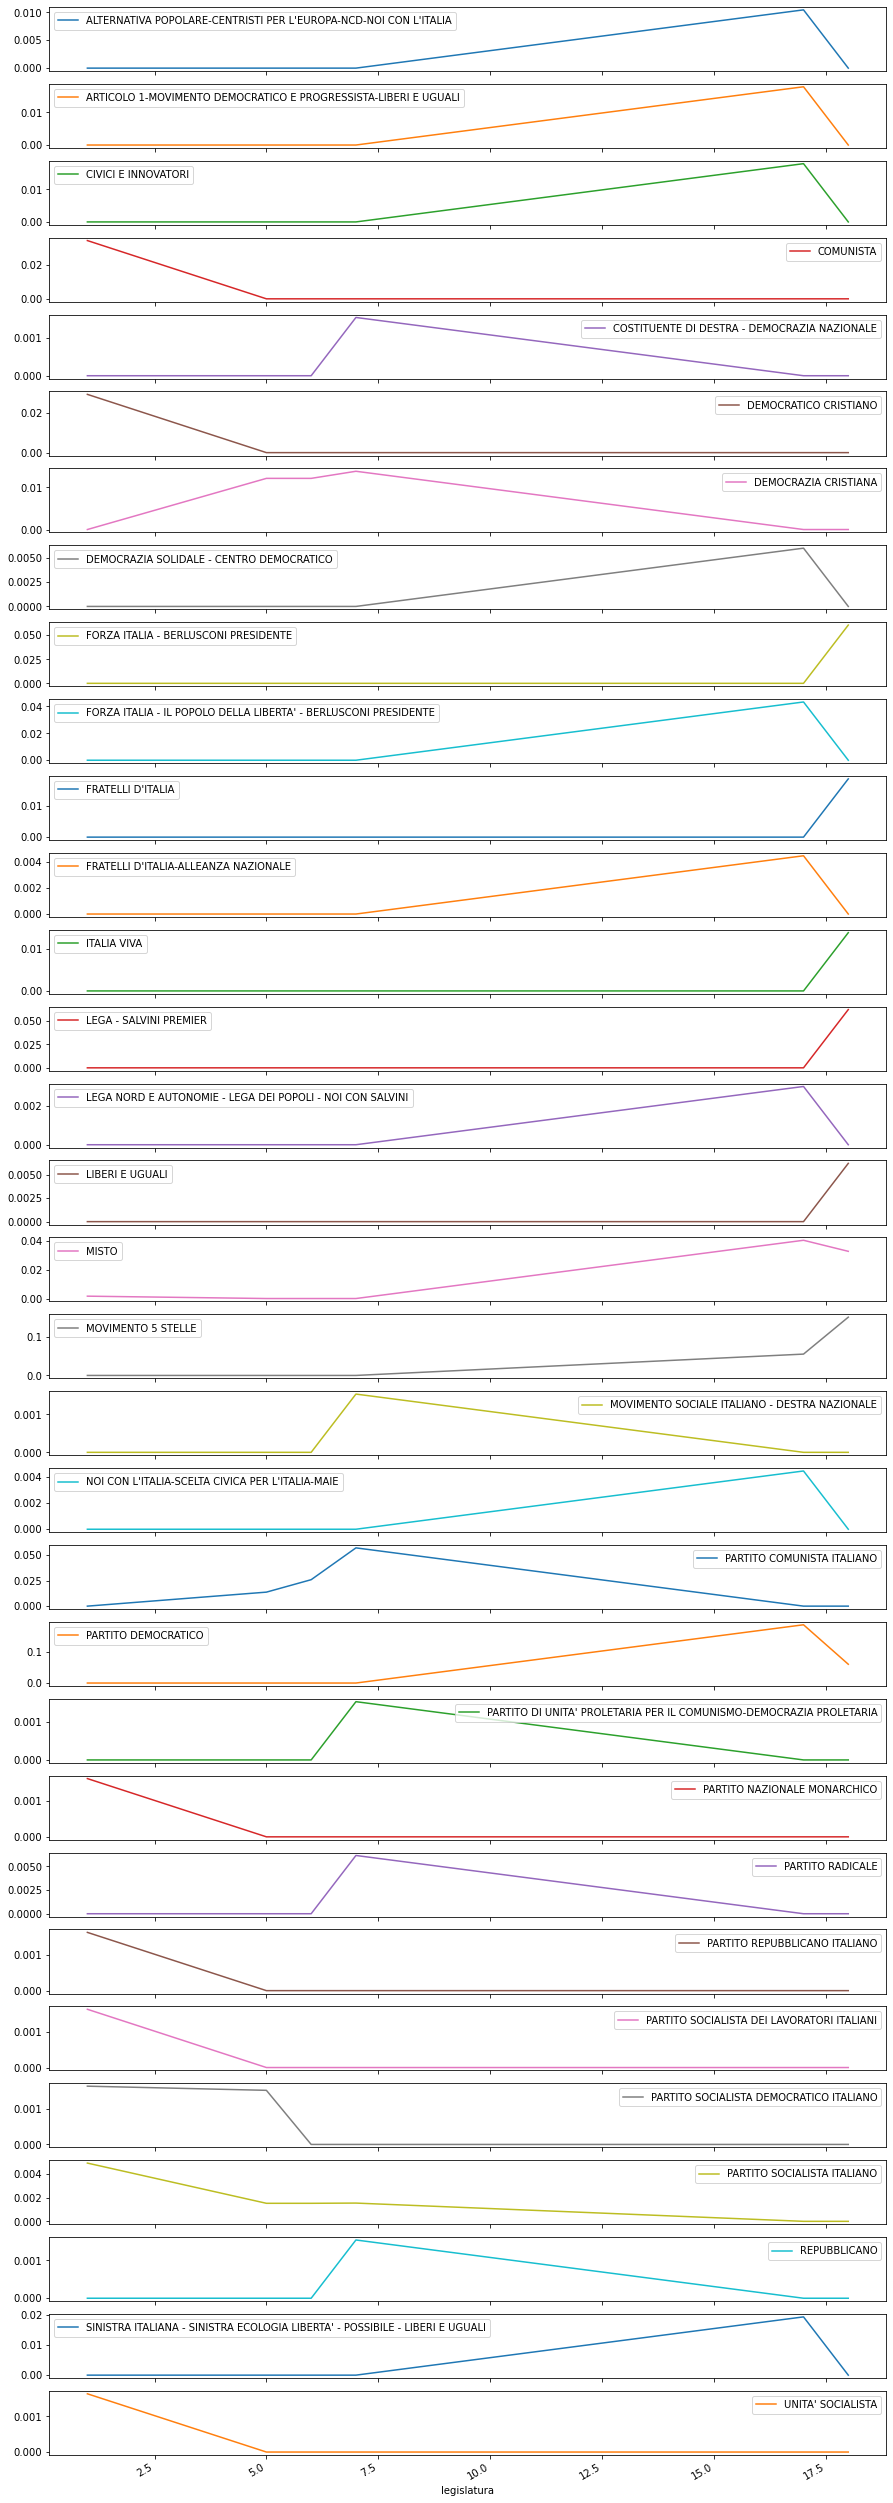

In [ ]:
result1_filtered.plot.line(figsize=(15,50), subplots=True)

In [ ]:
result1_filtered.T

legislatura,1,5,6,7,17,18
ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,0.000000,0.000000,0.000000,0.000000,0.010432,0.000000
ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,0.000000,0.000000,0.000000,0.000000,0.017884,0.000000
CIVICI E INNOVATORI,0.000000,0.000000,0.000000,0.000000,0.017884,0.000000
COMUNISTA,0.034314,0.000000,0.000000,0.000000,0.000000,0.000000
COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,0.000000,0.000000,0.000000,0.001536,0.000000,0.000000
DEMOCRATICO CRISTIANO,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000
DEMOCRAZIA CRISTIANA,0.000000,0.012140,0.012140,0.013825,0.000000,0.000000
DEMOCRAZIA SOLIDALE - CENTRO DEMOCRATICO,0.000000,0.000000,0.000000,0.000000,0.005961,0.000000
FORZA ITALIA - BERLUSCONI PRESIDENTE,0.000000,0.000000,0.000000,0.000000,0.000000,0.060559
FORZA ITALIA - IL POPOLO DELLA LIBERTA' - BERLUSCONI PRESIDENTE,0.000000,0.000000,0.000000,0.000000,0.043219,0.000000


In [ ]:
result1.describe()
# per colonna; fa la media di uno stesso party per tutte le leg

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CENTRO CRISTIANO DEMOCRATICO,CIVICI E INNOVATORI,COMUNISTA,COMUNISTI ITALIANI,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DCA-DEMOCRAZIA CRISTIANA PER LE AUTONOMIE-NUOVO PSI,DEMOCRATICI - L'ULIVO,...,SINISTRA DEMOCRATICA. PER IL SOCIALISMO EUROPEO,SINISTRA INDIPENDENTE,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,SOCIALISTI E RADICALI-RNP,UDR - UNIONE DEMOCRATICA PER LA REPUBBLICA,UNIONE DEMOCRATICA PER L'EUROPA,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA,VERDE,VERDI
count,6.0,6.000000,6.000000,6.0,6.000000,6.000000,6.0,6.000000,6.0,6.0,...,6.0,6.0,6.000000,6.0,6.0,6.0,6.0,6.000000,6.0,6.0
mean,0.0,0.001739,0.002981,0.0,0.002981,0.005719,0.0,0.000256,0.0,0.0,...,0.0,0.0,0.003229,0.0,0.0,0.0,0.0,0.000272,0.0,0.0
std,0.0,0.004259,0.007301,0.0,0.007301,0.014009,0.0,0.000627,0.0,0.0,...,0.0,0.0,0.007909,0.0,0.0,0.0,0.0,0.000667,0.0,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
max,0.0,0.010432,0.017884,0.0,0.017884,0.034314,0.0,0.001536,0.0,0.0,...,0.0,0.0,0.019374,0.0,0.0,0.0,0.0,0.001634,0.0,0.0


In [ ]:
#by row
#mean of all party per legis
result1.T.describe()

legislatura,1,5,6,7,17,18
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,0.000912,0.000335,0.000459,0.000982,0.004766,0.004713
std,0.004864,0.001967,0.003062,0.006313,0.021974,0.019886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.034314,0.013657,0.025797,0.056836,0.187779,0.150621


In [ ]:
#2) Number of fem per party / tot dept per party per legis
#See how the fem representantion inside that party changes for each legis

In [ ]:
result=distr_gend_per_part_per_leg["ALLEANZA NAZIONALE", "female"]/(distr_gend_per_part_per_leg["ALLEANZA NAZIONALE", "female"] + distr_gend_per_part_per_leg["ALLEANZA NAZIONALE", "male"])*100
for party in tqdm(parties1):
    res = distr_gend_per_part_per_leg[party, "female"]/(distr_gend_per_part_per_leg[party, "female"] + distr_gend_per_part_per_leg[party, "male"])*100
    result = pd.concat([result, res], axis="columns")

100%|██████████| 85/85 [00:00<00:00, 532.38it/s]


In [ ]:
result.columns = np.sort(df.party.unique())
result = result.fillna(0)

In [ ]:
#result = result.drop([2,3,4,8,9,10,11,12,13,14,15,16])

In [ ]:
result

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CENTRO CRISTIANO DEMOCRATICO,CIVICI E INNOVATORI,COMUNISTA,COMUNISTI ITALIANI,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DCA-DEMOCRAZIA CRISTIANA PER LE AUTONOMIE-NUOVO PSI,DEMOCRATICI - L'ULIVO,...,SINISTRA DEMOCRATICA. PER IL SOCIALISMO EUROPEO,SINISTRA INDIPENDENTE,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,SOCIALISTI E RADICALI-RNP,UDR - UNIONE DEMOCRATICA PER LA REPUBBLICA,UNIONE DEMOCRATICA PER L'EUROPA,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA,VERDE,VERDI
legislatura,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.0,0.000000,15.441176,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.0,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,5.555556,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
17,0.0,17.073171,27.272727,0.0,22.222222,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
18,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
result.T.describe()

legislatura,1,5,6,7,17,18
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,0.624405,0.144122,0.159715,1.084435,3.140063,3.061885
std,2.216515,0.722631,1.052449,5.025720,8.433419,9.718173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.441176,4.972376,9.239130,40.000000,37.168142,43.497758


In [ ]:
result.describe()

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CENTRO CRISTIANO DEMOCRATICO,CIVICI E INNOVATORI,COMUNISTA,COMUNISTI ITALIANI,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DCA-DEMOCRAZIA CRISTIANA PER LE AUTONOMIE-NUOVO PSI,DEMOCRATICI - L'ULIVO,...,SINISTRA DEMOCRATICA. PER IL SOCIALISMO EUROPEO,SINISTRA INDIPENDENTE,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,SOCIALISTI E RADICALI-RNP,UDR - UNIONE DEMOCRATICA PER LA REPUBBLICA,UNIONE DEMOCRATICA PER L'EUROPA,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA,VERDE,VERDI
count,6.0,6.000000,6.000000,6.0,6.000000,6.000000,6.0,6.000000,6.0,6.0,...,6.0,6.0,6.000000,6.0,6.0,6.0,6.0,6.000000,6.0,6.0
mean,0.0,2.845528,4.545455,0.0,3.703704,2.573529,0.0,0.925926,0.0,0.0,...,0.0,0.0,4.333333,0.0,0.0,0.0,0.0,0.476190,0.0,0.0
std,0.0,6.970093,11.134044,0.0,9.072184,6.303834,0.0,2.268046,0.0,0.0,...,0.0,0.0,10.614456,0.0,0.0,0.0,0.0,1.166424,0.0,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
max,0.0,17.073171,27.272727,0.0,22.222222,15.441176,0.0,5.555556,0.0,0.0,...,0.0,0.0,26.000000,0.0,0.0,0.0,0.0,2.857143,0.0,0.0


In [ ]:
result_filtered = result.loc[:, (result != 0).any(axis=0)]

<AxesSubplot:xlabel='legislatura'>

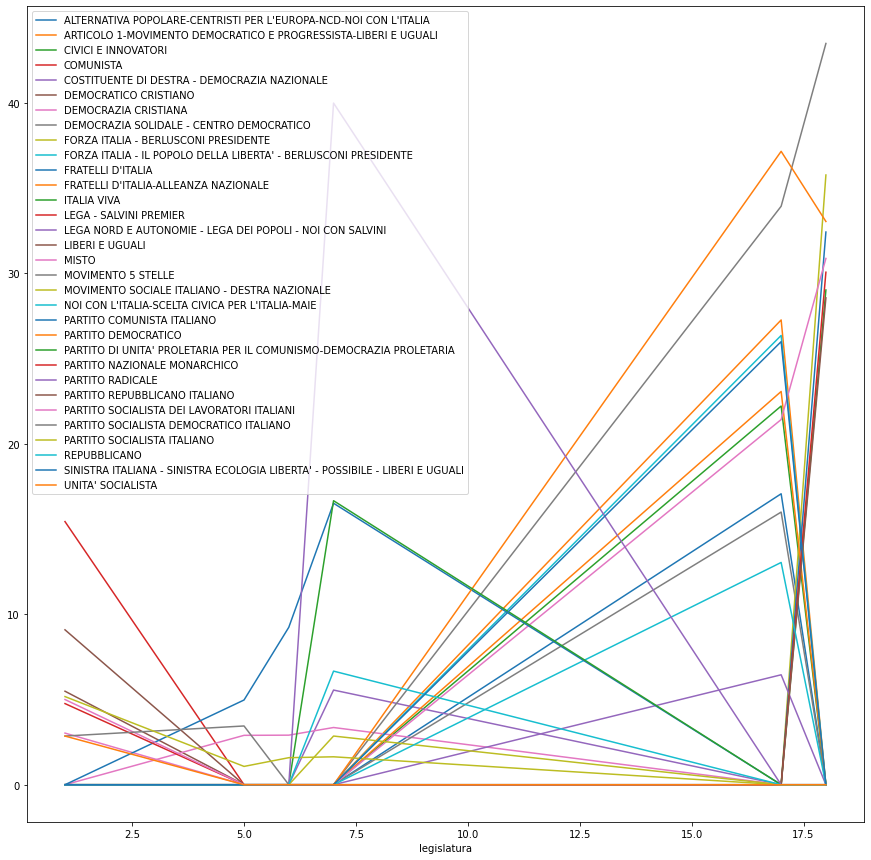

In [ ]:
result_filtered.plot.line(figsize=(15,15))

array([<AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <AxesSubplot:xlabel='legislatura'>,
       <Axe

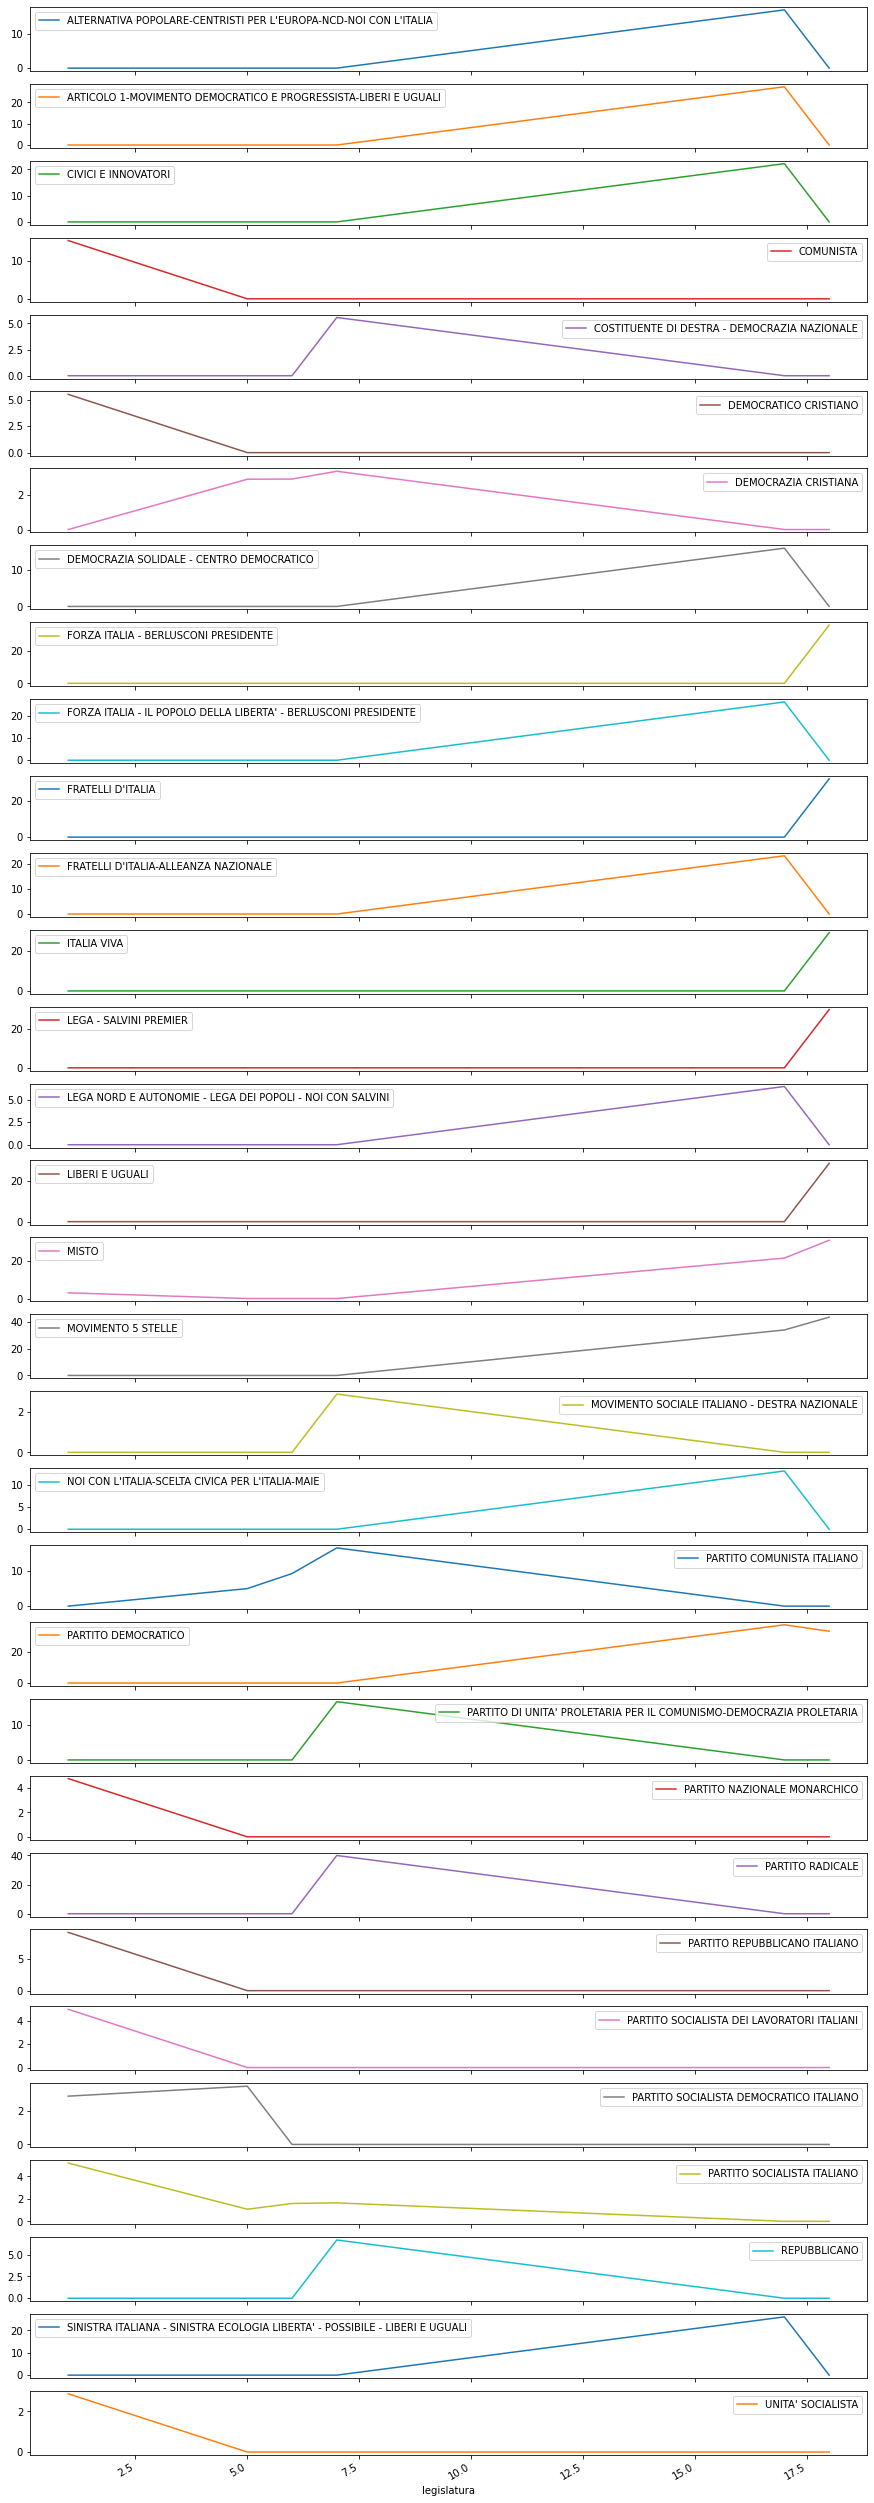

In [ ]:
result_filtered.plot.line(figsize=(15,50), subplots=True)

In [ ]:
result_filtered.T

legislatura,1,5,6,7,17,18
ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,0.000000,0.000000,0.000000,0.000000,17.073171,0.000000
ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,0.000000,0.000000,0.000000,0.000000,27.272727,0.000000
CIVICI E INNOVATORI,0.000000,0.000000,0.000000,0.000000,22.222222,0.000000
COMUNISTA,15.441176,0.000000,0.000000,0.000000,0.000000,0.000000
COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,0.000000,0.000000,0.000000,5.555556,0.000000,0.000000
DEMOCRATICO CRISTIANO,5.487805,0.000000,0.000000,0.000000,0.000000,0.000000
DEMOCRAZIA CRISTIANA,0.000000,2.898551,2.909091,3.358209,0.000000,0.000000
DEMOCRAZIA SOLIDALE - CENTRO DEMOCRATICO,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000
FORZA ITALIA - BERLUSCONI PRESIDENTE,0.000000,0.000000,0.000000,0.000000,0.000000,35.779817
FORZA ITALIA - IL POPOLO DELLA LIBERTA' - BERLUSCONI PRESIDENTE,0.000000,0.000000,0.000000,0.000000,26.363636,0.000000


In [ ]:
#3) Number of fem speeches per party / tot speeches per legis
#See how much fem of a party speak wrt all speeches in that legis

In [ ]:
df_speeches.dropna(subset=["party"], inplace=True)
parties2 = np.sort(df_speeches.party.unique())
parties2 = np.delete(parties2,0)

In [ ]:
result2=sp_per_party["ALLEANZA NAZIONALE", "female"]/sp_per_party["Total"].drop(["Total"])
for party in tqdm(parties2):
    res = sp_per_party[party, "female"]/sp_per_party["Total"].drop(["Total"])
    result2 = pd.concat([result2, res], axis="columns")

100%|██████████| 54/54 [00:00<00:00, 512.32it/s]


In [ ]:
result2.columns = np.sort(df_speeches.party.unique())
result2 = result2.fillna(0)

In [ ]:
result2 = result2.drop(["Total"])
result2

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CIVICI E INNOVATORI,COMUNISTA,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DEMOCRATICI DI SINISTRA - L'ULIVO,DEMOCRATICI DI SINISTRA-L'ULIVO,DEMOCRATICO CRISTIANO,DEMOCRATICO CRISTIANO - PARTITO POPOLARE ITALIANO,...,PARTITO SOCIALISTA ITALIANO DI UNITA' PROLETARIA,PARTITO SOCIALISTA UNITARIO,POPOLO DELLA LIBERTA',REPUBBLICANO,RIFONDAZIONE COMUNISTA,RIFONDAZIONE COMUNISTA - PROGRESSISTI,RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA
legislature,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.005253,0.000000,0.0,0.000000,0.005597,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.003308,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000033,0.0,0.000000,0.000000,0.0,0.0
6,0.000064,0.000021,0.000000,0.000000,0.001441,0.000000,0.0,0.000021,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000085,0.0,0.000021,0.000000,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000926,0.002553,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.001084,0.000000,0.0,0.000000,0.000000,0.0,0.0
17,0.000000,0.002787,0.001339,0.004856,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000022,0.000000,0.000000,0.0,0.000000,0.016560,0.0,0.0
18,0.000000,0.000059,0.002641,0.000000,0.000030,0.000000,0.0,0.000059,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000831,0.0,0.0


In [ ]:
result2_filtered = result2.loc[:, (result2 != 0).any(axis=0)]

<AxesSubplot:xlabel='legislature'>

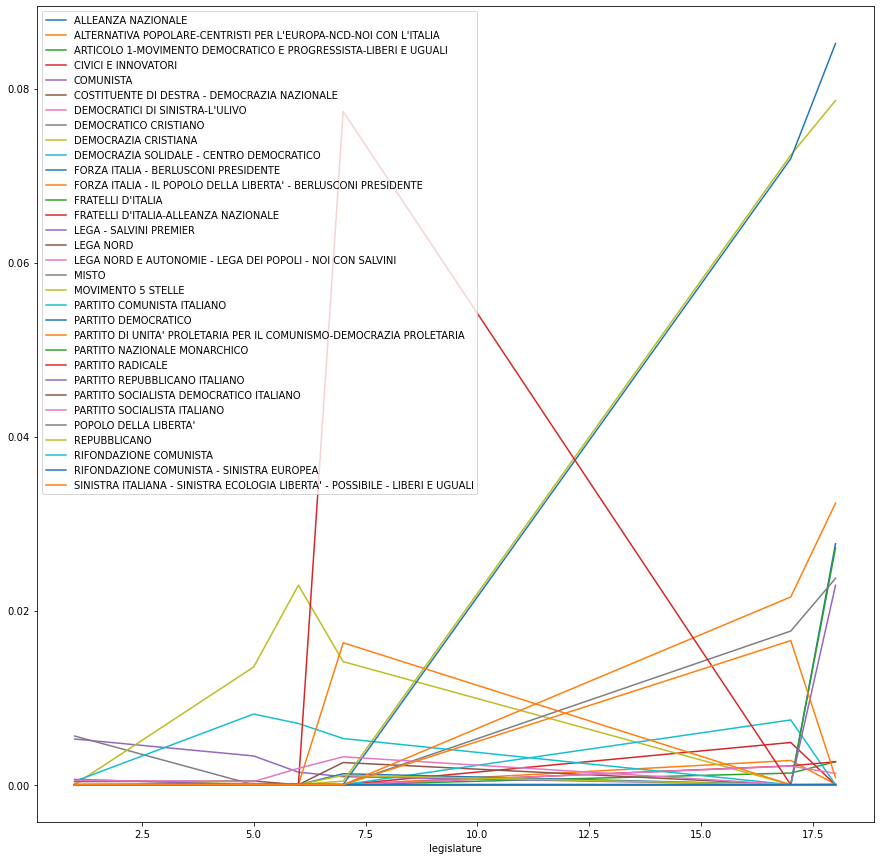

In [ ]:
result2_filtered.plot.line(figsize=(15,15))

array([<AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <Axe

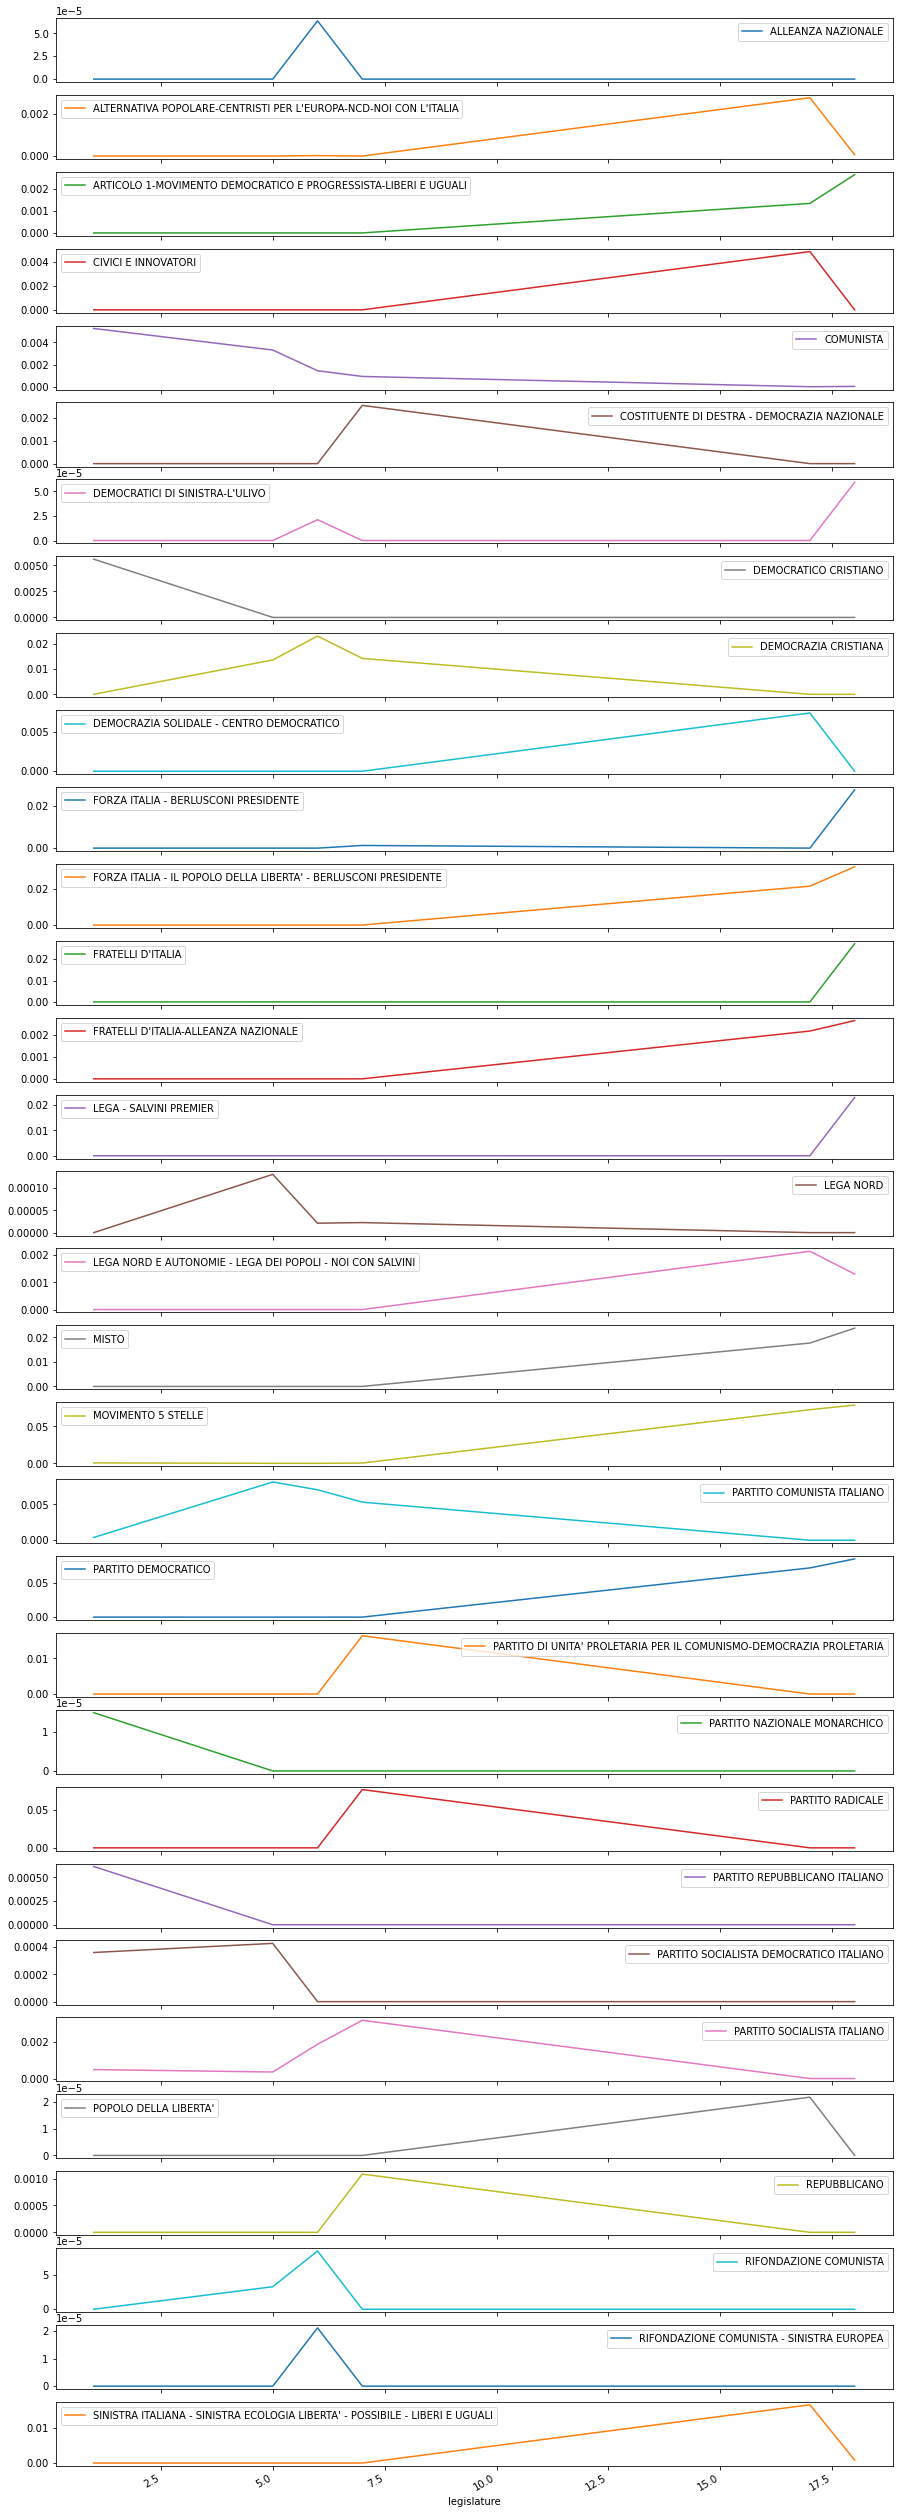

In [ ]:
result2_filtered.plot.line(figsize=(15,50), subplots=True)

In [ ]:
result2_filtered.T

legislature,1,5,6,7,17,18
ALLEANZA NAZIONALE,0.000000,0.000000,0.000064,0.000000,0.000000,0.000000
ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,0.000000,0.000000,0.000021,0.000000,0.002787,0.000059
ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,0.000000,0.000000,0.000000,0.000000,0.001339,0.002641
CIVICI E INNOVATORI,0.000000,0.000000,0.000000,0.000000,0.004856,0.000000
COMUNISTA,0.005253,0.003308,0.001441,0.000926,0.000000,0.000030
COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,0.000000,0.000000,0.000000,0.002553,0.000000,0.000000
DEMOCRATICI DI SINISTRA-L'ULIVO,0.000000,0.000000,0.000021,0.000000,0.000000,0.000059
DEMOCRATICO CRISTIANO,0.005597,0.000000,0.000000,0.000000,0.000000,0.000000
DEMOCRAZIA CRISTIANA,0.000015,0.013527,0.022934,0.014143,0.000000,0.000000
DEMOCRAZIA SOLIDALE - CENTRO DEMOCRATICO,0.000000,0.000000,0.000000,0.000000,0.007447,0.000000


In [ ]:
result2.describe()

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CIVICI E INNOVATORI,COMUNISTA,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DEMOCRATICI DI SINISTRA - L'ULIVO,DEMOCRATICI DI SINISTRA-L'ULIVO,DEMOCRATICO CRISTIANO,DEMOCRATICO CRISTIANO - PARTITO POPOLARE ITALIANO,...,PARTITO SOCIALISTA ITALIANO DI UNITA' PROLETARIA,PARTITO SOCIALISTA UNITARIO,POPOLO DELLA LIBERTA',REPUBBLICANO,RIFONDAZIONE COMUNISTA,RIFONDAZIONE COMUNISTA - PROGRESSISTI,RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.0,...,6.0,6.0,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.0,6.0
mean,0.000011,0.000478,0.000663,0.000809,0.001826,0.000426,0.0,0.000013,0.000933,0.0,...,0.0,0.0,0.000004,0.000181,0.000020,0.0,0.000004,0.002899,0.0,0.0
std,0.000026,0.001132,0.001107,0.001982,0.002072,0.001042,0.0,0.000024,0.002285,0.0,...,0.0,0.0,0.000009,0.000443,0.000035,0.0,0.000009,0.006701,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000254,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000011,0.000000,0.000000,0.001184,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
75%,0.000000,0.000050,0.001004,0.000000,0.002841,0.000000,0.0,0.000016,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000025,0.0,0.000000,0.000623,0.0,0.0
max,0.000064,0.002787,0.002641,0.004856,0.005253,0.002553,0.0,0.000059,0.005597,0.0,...,0.0,0.0,0.000022,0.001084,0.000085,0.0,0.000021,0.016560,0.0,0.0


In [ ]:
result2.T.describe()

legislature,1,5,6,7,17,18
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.000242,0.000473,0.000610,0.002229,0.004016,0.005550
std,0.001027,0.002143,0.003222,0.010738,0.014060,0.016887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015
max,0.005597,0.013527,0.022934,0.077359,0.072359,0.085178


In [ ]:
#4) Number of speeches of fem per party / tot speeches per party per legis
#See how much fem of a party speak wrt that very same party per legis

In [ ]:
result3=sp_per_party["ALLEANZA NAZIONALE", "female"]/(sp_per_party["ALLEANZA NAZIONALE", "female"] + sp_per_party["ALLEANZA NAZIONALE", "male"])
for party in tqdm(parties2):
    res = sp_per_party[party, "female"]/(sp_per_party[party, "female"] + sp_per_party[party, "male"])
    result3 = pd.concat([result3, res], axis="columns")

100%|██████████| 54/54 [00:00<00:00, 887.75it/s]


In [ ]:
result3.columns = np.sort(df_speeches.party.unique())
result3 = result3.fillna(0)

In [ ]:
result3 = result3.drop(["Total"])
result3

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CIVICI E INNOVATORI,COMUNISTA,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DEMOCRATICI DI SINISTRA - L'ULIVO,DEMOCRATICI DI SINISTRA-L'ULIVO,DEMOCRATICO CRISTIANO,DEMOCRATICO CRISTIANO - PARTITO POPOLARE ITALIANO,...,PARTITO SOCIALISTA ITALIANO DI UNITA' PROLETARIA,PARTITO SOCIALISTA UNITARIO,POPOLO DELLA LIBERTA',REPUBBLICANO,RIFONDAZIONE COMUNISTA,RIFONDAZIONE COMUNISTA - PROGRESSISTI,RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA
legislature,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.022431,0.000000,0.0,0.0,0.013039,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.227222,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.4,0.0,0.0,0.000000,0.0,0.0
6,0.5,1.000000,0.000000,0.000000,0.160757,0.000000,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.286713,0.118077,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.096774,0.0,0.0,0.0,0.000000,0.0,0.0
17,0.0,0.208809,0.436170,0.135439,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.055556,0.000000,0.0,0.0,0.0,0.178124,0.0,0.0
18,0.0,0.080000,0.505682,0.000000,0.055556,0.000000,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.035944,0.0,0.0


In [ ]:
result3_filtered = result3.loc[:, (result3 != 0).any(axis=0)]

<AxesSubplot:xlabel='legislature'>

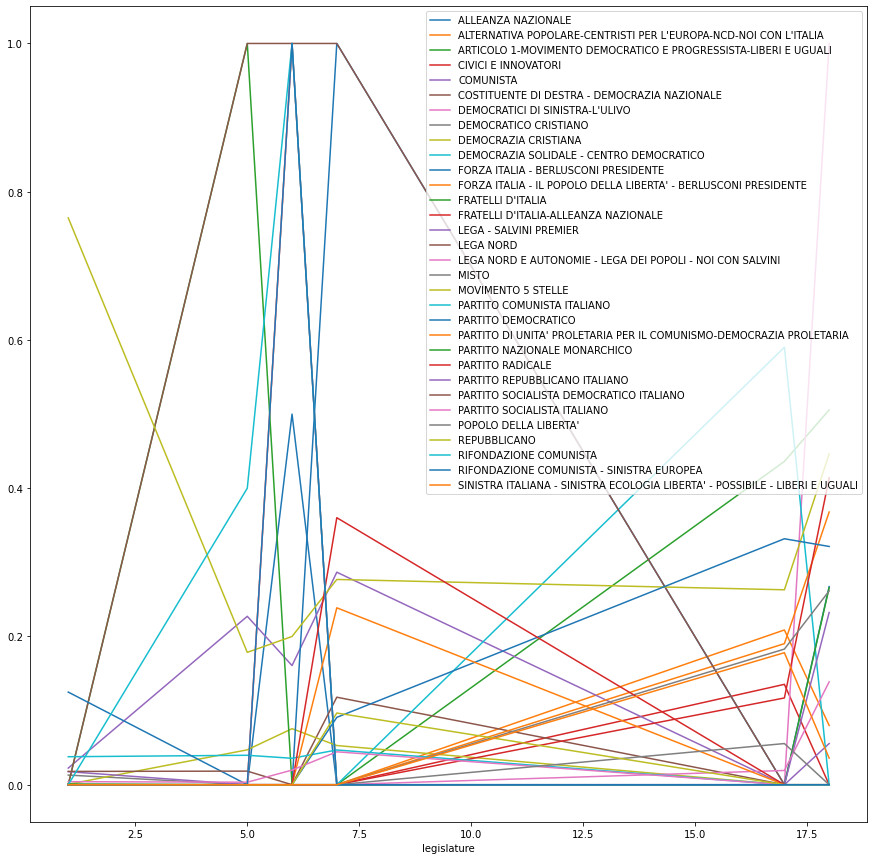

In [ ]:
result3_filtered.plot.line(figsize=(15,15))

array([<AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <AxesSubplot:xlabel='legislature'>,
       <Axe

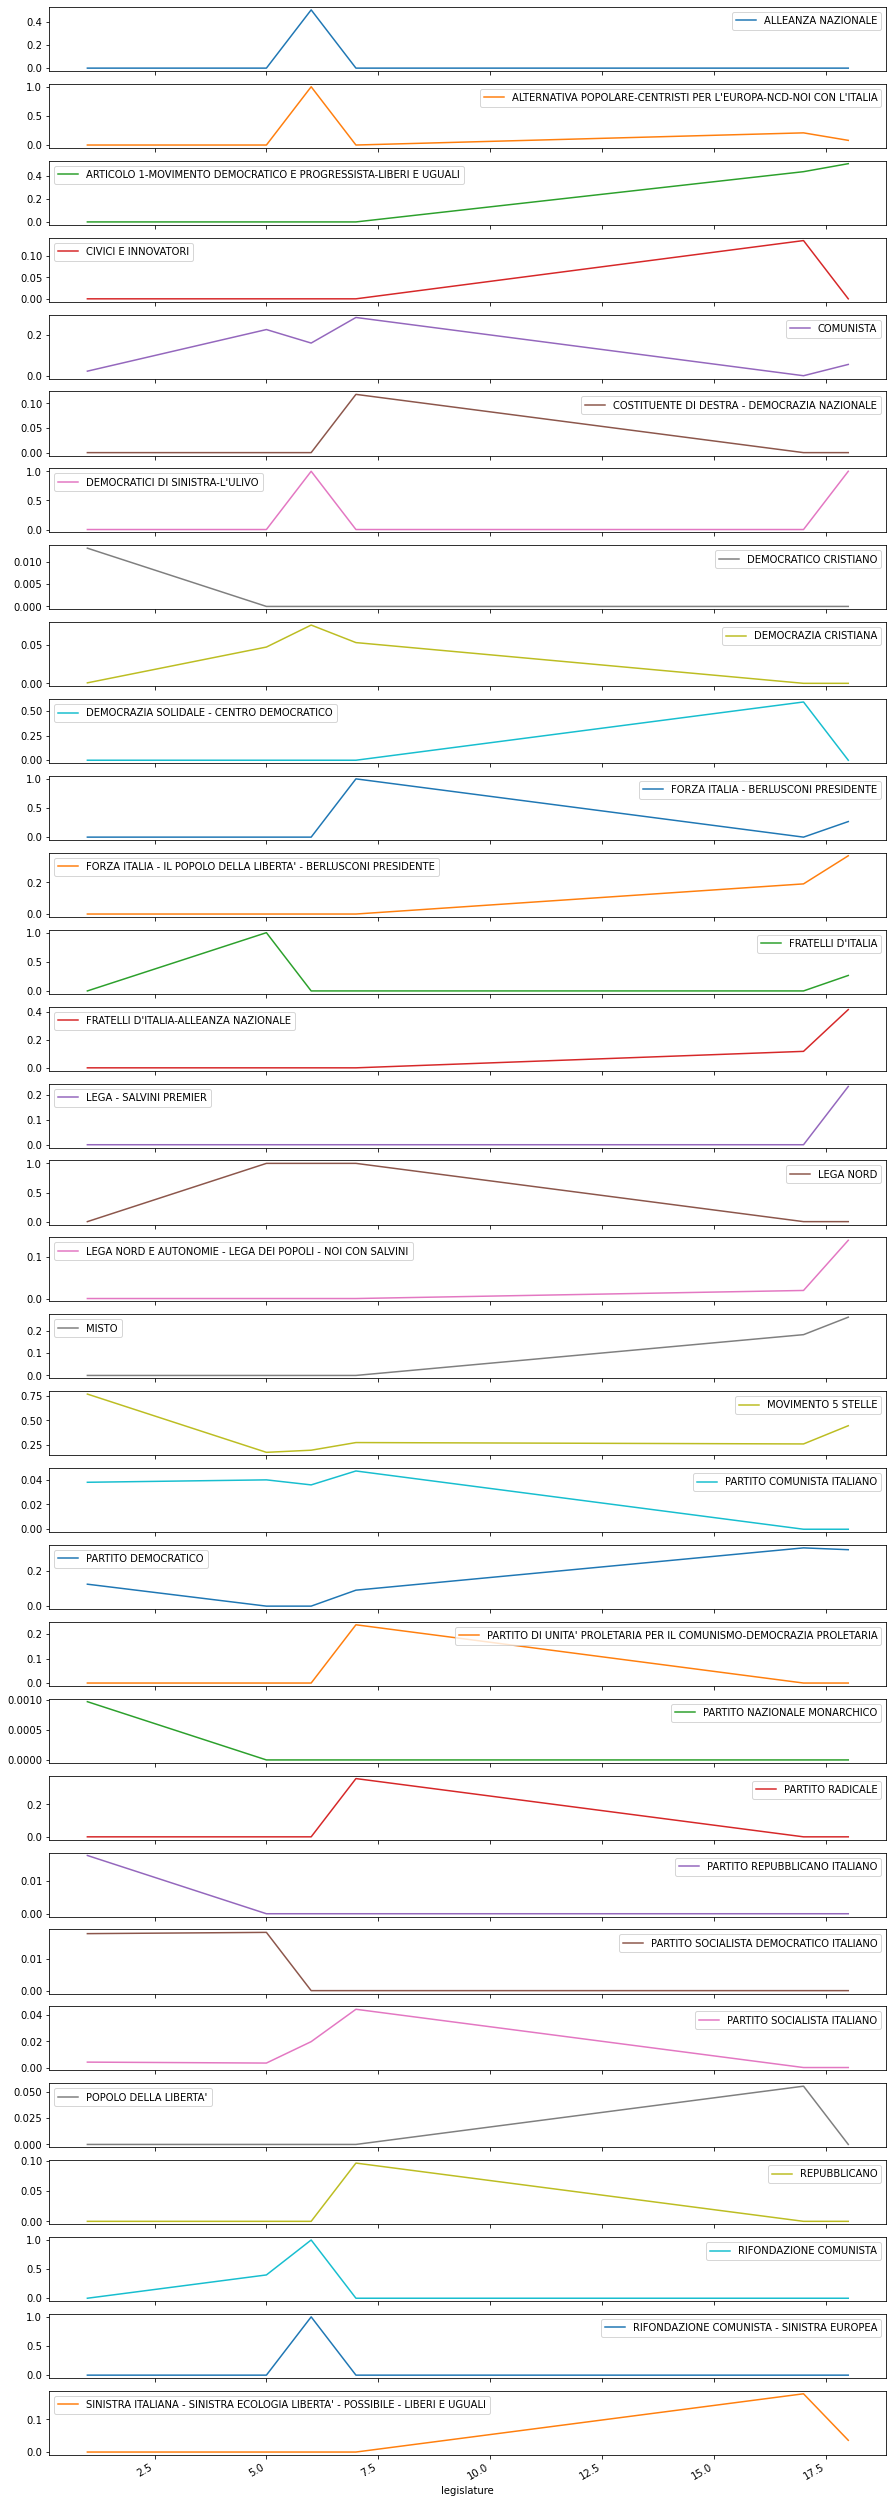

In [ ]:
result3_filtered.plot.line(figsize=(15,50), subplots=True)

In [ ]:
result3.describe()

,ALLEANZA NAZIONALE,ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,CIVICI E INNOVATORI,COMUNISTA,COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,DEMOCRATICI DI SINISTRA - L'ULIVO,DEMOCRATICI DI SINISTRA-L'ULIVO,DEMOCRATICO CRISTIANO,DEMOCRATICO CRISTIANO - PARTITO POPOLARE ITALIANO,...,PARTITO SOCIALISTA ITALIANO DI UNITA' PROLETARIA,PARTITO SOCIALISTA UNITARIO,POPOLO DELLA LIBERTA',REPUBBLICANO,RIFONDAZIONE COMUNISTA,RIFONDAZIONE COMUNISTA - PROGRESSISTI,RIFONDAZIONE COMUNISTA - SINISTRA EUROPEA,SINISTRA ITALIANA - SINISTRA ECOLOGIA LIBERTA' - POSSIBILE - LIBERI E UGUALI,UNIONE DI CENTRO PER IL TERZO POLO,UNITA' SOCIALISTA
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.0,...,6.0,6.0,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.0,6.0
mean,0.083333,0.214802,0.156975,0.022573,0.125446,0.019680,0.0,0.333333,0.002173,0.0,...,0.0,0.0,0.009259,0.016129,0.233333,0.0,0.166667,0.035678,0.0,0.0
std,0.204124,0.393234,0.244177,0.055293,0.117342,0.048205,0.0,0.516398,0.005323,0.0,...,0.0,0.0,0.022680,0.039508,0.408248,0.0,0.408248,0.071250,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.030712,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.000000,0.040000,0.000000,0.000000,0.108156,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
75%,0.000000,0.176607,0.327128,0.000000,0.210605,0.000000,0.0,0.750000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.300000,0.0,0.000000,0.026958,0.0,0.0
max,0.500000,1.000000,0.505682,0.135439,0.286713,0.118077,0.0,1.000000,0.013039,0.0,...,0.0,0.0,0.055556,0.096774,1.000000,0.0,1.000000,0.178124,0.0,0.0


In [ ]:
result3.T.describe()

legislature,1,5,6,7,17,18
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.018260,0.052989,0.108942,0.065682,0.049249,0.079863
std,0.104067,0.196885,0.294092,0.199392,0.119021,0.183011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.017972
max,0.764706,1.000000,1.000000,1.000000,0.590164,1.000000


In [ ]:
result3_filtered.T

legislature,1,5,6,7,17,18
ALLEANZA NAZIONALE,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
ALTERNATIVA POPOLARE-CENTRISTI PER L'EUROPA-NCD-NOI CON L'ITALIA,0.000000,0.000000,1.000000,0.000000,0.208809,0.080000
ARTICOLO 1-MOVIMENTO DEMOCRATICO E PROGRESSISTA-LIBERI E UGUALI,0.000000,0.000000,0.000000,0.000000,0.436170,0.505682
CIVICI E INNOVATORI,0.000000,0.000000,0.000000,0.000000,0.135439,0.000000
COMUNISTA,0.022431,0.227222,0.160757,0.286713,0.000000,0.055556
COSTITUENTE DI DESTRA - DEMOCRAZIA NAZIONALE,0.000000,0.000000,0.000000,0.118077,0.000000,0.000000
DEMOCRATICI DI SINISTRA-L'ULIVO,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
DEMOCRATICO CRISTIANO,0.013039,0.000000,0.000000,0.000000,0.000000,0.000000
DEMOCRAZIA CRISTIANA,0.000618,0.047092,0.075627,0.052885,0.000000,0.000000
DEMOCRAZIA SOLIDALE - CENTRO DEMOCRATICO,0.000000,0.000000,0.000000,0.000000,0.590164,0.000000
